# телекоммуникации: исследование оттока клиентов

## введение: описание и цели проекта

**Описание:**  
заказ на разработку проекта, связанного с анализом оттока пользователей услуг связи. Требуется качественная модель машинного обучения, предсказывающая уход клиентов (ROC-AUC >= 0.85).

**Бизнес-метрики и боли:**   
Сейчас это убытки, связанные с неэффективными акциями по удержанию клиентов с помощью промо-купонов, скидок и прочих пакетов стимулирования. Маркетологи компании выделяют две болевые точки:
1) пользователю предложили промокоды, но он не собирался уходить;  
2) пользователю ничего не предложили и он ушёл.  

**Ожидаемый результат:**  
ROC-AUC (дополнительно можно и F-меру) - информативные метрики для аналитика,   
для заказчика на тестовой выборке - accuracy и матрица ошибок.

___
## **План работы:**  
1. загрузка и ознакомление с данными (по каждому датасету в отдельности);
2. Объединение данных в один датасет;
3. изучение целевого признака;
4. исследование данных (разведочный анализ, EDA) для объединенного датасета;
5. предобработка данных и разработка моделей:  
    5.1. выделение целевого признака после предобработки данных;  
    5.2. подготовка синтечиских признаков;  
    5.3. проверка корреляции с целевой переменной;  
    5.4. предотвращение мультиколлениарности;  
    5.5. отбор признаков для моделей;  
    5.6. предотвращение утечки данных;  
    5.7. разбиение данных на обучающую и тестовую выборки;  
    5.8. кодирование данных;  
    5.9. подбор гиперпараметров;  
    5.10. Исследование модей разной архитектуры (планируется рассмотреть три модели: catboost, случайный лес и линейную модель)
6. Проверка одной лучшей модели на тестовой выборке (построение графика ROC, анализ второй метрики accuracy для заказчика, построение матрицы ошибок и анализ важности признаков выбранной модели)
7. составление отчета.
___

## загрузка и ознакомление с данными

In [1]:
# импорт библиотек, настройки и константы
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import datetime

#настройки
sns.set(style='ticks', context='paper')
pd.set_option('display.max_rows', None)
#константы
RANDOM_STATE = 30723

In [2]:
#импорт сторонних библиотек
! pip install phik
import phik
from phik.report import plot_correlation_matrix
from phik import report

In [3]:
#импорт сторонних библиотек
!pip install -U scikit-learn

In [4]:
!pip install shap

In [5]:
# импорты модулей текущего проекта
from sklearn.model_selection import (
    GridSearchCV, 
    RandomizedSearchCV,
    train_test_split)

from sklearn.compose import make_column_transformer
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import (
    OneHotEncoder,
    OrdinalEncoder,
    StandardScaler
)

from sklearn.metrics import (
    roc_auc_score, 
    roc_curve, 
    f1_score,
    confusion_matrix,
    accuracy_score
)

from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestClassifier


from catboost import CatBoostClassifier
from catboost import cv, Pool
from catboost.utils import get_roc_curve
import sklearn
from sklearn import metrics


from catboost.utils import select_threshold
import shap

import warnings
warnings.filterwarnings('ignore')

Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)


In [6]:
#путь к df
path_local = '/Users/evgenij/Desktop/DS/git_portfolio/telecom/'

In [7]:
#загрузка df
contract_df = pd.read_csv(path_local + 'contract_new.csv')
internet_df = pd.read_csv(path_local + 'internet_new.csv')
personal_df = pd.read_csv(path_local + 'personal_new.csv')
phone_df = pd.read_csv(path_local + 'phone_new.csv')

In [8]:
# выведем краткую информацию о датасетах
def get_data_info(data):
    print('количество строк и столбцов:',data.shape)
    display(data.sample(5))
    data.info()
    display(data.describe(include='all'))
    print('количество дубликатов:',data.duplicated().sum())
    print('количество пропусков:\n', data.isna().sum())

### анализ данных по информации о договорах (contract_df)

 - contract_new.csv - информация о договоре
    - BeginDate - дата начала пользования услугами
    - EndDate - дата окончания пользования услугами
    - Type - тип договора: ежемесячный, годовой и т.д
    - PaperlessBilling - выставления счёта по электронной почте
    - PaymentMethod - способ оплаты
    - MonthlyCharges - ежемесячные траты на услуги
    - TotalCharges - всего потрачено денег на услуги

In [9]:
get_data_info(contract_df)

количество строк и столбцов: (7043, 8)


customerID   BeginDate EndDate            Type PaperlessBilling  \
4339  6992-TKNYO  2016-12-01      No        One year               No   
252   9514-JDSKI  2019-11-01      No  Month-to-month               No   
2745  4826-XTSOH  2019-10-01      No  Month-to-month              Yes   
3588  9643-YBLUR  2019-05-01      No  Month-to-month              Yes   
6831  9451-LPGOO  2019-04-01      No  Month-to-month              Yes   

                PaymentMethod  MonthlyCharges TotalCharges  
4339  Credit card (automatic)           69.00       2884.2  
252          Electronic check           40.20       129.04  
2745         Electronic check           86.05        344.2  
3588  Credit card (automatic)           69.05       621.45  
6831         Electronic check           86.80        868.0

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   object 
dtypes: float64(1), object(7)
memory usage: 440.3+ KB


customerID   BeginDate EndDate            Type PaperlessBilling  \
count         7043        7043    7043            7043             7043   
unique        7043          77      67               3                2   
top     7590-VHVEG  2014-02-01      No  Month-to-month              Yes   
freq             1         366    5942            3875             4171   
mean           NaN         NaN     NaN             NaN              NaN   
std            NaN         NaN     NaN             NaN              NaN   
min            NaN         NaN     NaN             NaN              NaN   
25%            NaN         NaN     NaN             NaN              NaN   
50%            NaN         NaN     NaN             NaN              NaN   
75%            NaN         NaN     NaN             NaN              NaN   
max            NaN         NaN     NaN             NaN              NaN   

           PaymentMethod  MonthlyCharges TotalCharges  
count               7043     7043.000000         7043  
unique                 4             NaN         6658  
top     Electronic check             NaN               
freq                2365             NaN           11  
mean                 NaN       64.761692          NaN  
std                  NaN       30.090047          NaN  
min                  NaN       18.250000          NaN  
25%                  NaN       35.500000          NaN  
50%                  NaN       70.350000          NaN  
75%                  NaN       89.850000          NaN  
max                  NaN      118.750000          NaN

количество дубликатов: 0
количество пропусков:
 customerID          0
BeginDate           0
EndDate             0
Type                0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
dtype: int64


In [10]:
col_names = contract_df.columns.drop(['customerID', 'BeginDate', 'EndDate','MonthlyCharges', 'TotalCharges'])

In [11]:
for col in col_names:
    print(col, contract_df[col].unique())


Type ['Month-to-month' 'One year' 'Two year']
PaperlessBilling ['Yes' 'No']
PaymentMethod ['Electronic check' 'Mailed check' 'Bank transfer (automatic)'
 'Credit card (automatic)']


In [12]:
# выведем информацию о временным рамках по датасету
print('дата начала данных:',contract_df['BeginDate'].min(), '\nдата последних данных:', contract_df['BeginDate'].max())

дата начала данных: 2013-10-01 
дата последних данных: 2020-02-01


In [13]:
# выведем информацию о временным рамках по датасету
print('дата начала данных:',contract_df['EndDate'].min(), '\nдата последних данных:', contract_df['EndDate'].max())

дата начала данных: 2014-06-01 
дата последних данных: No


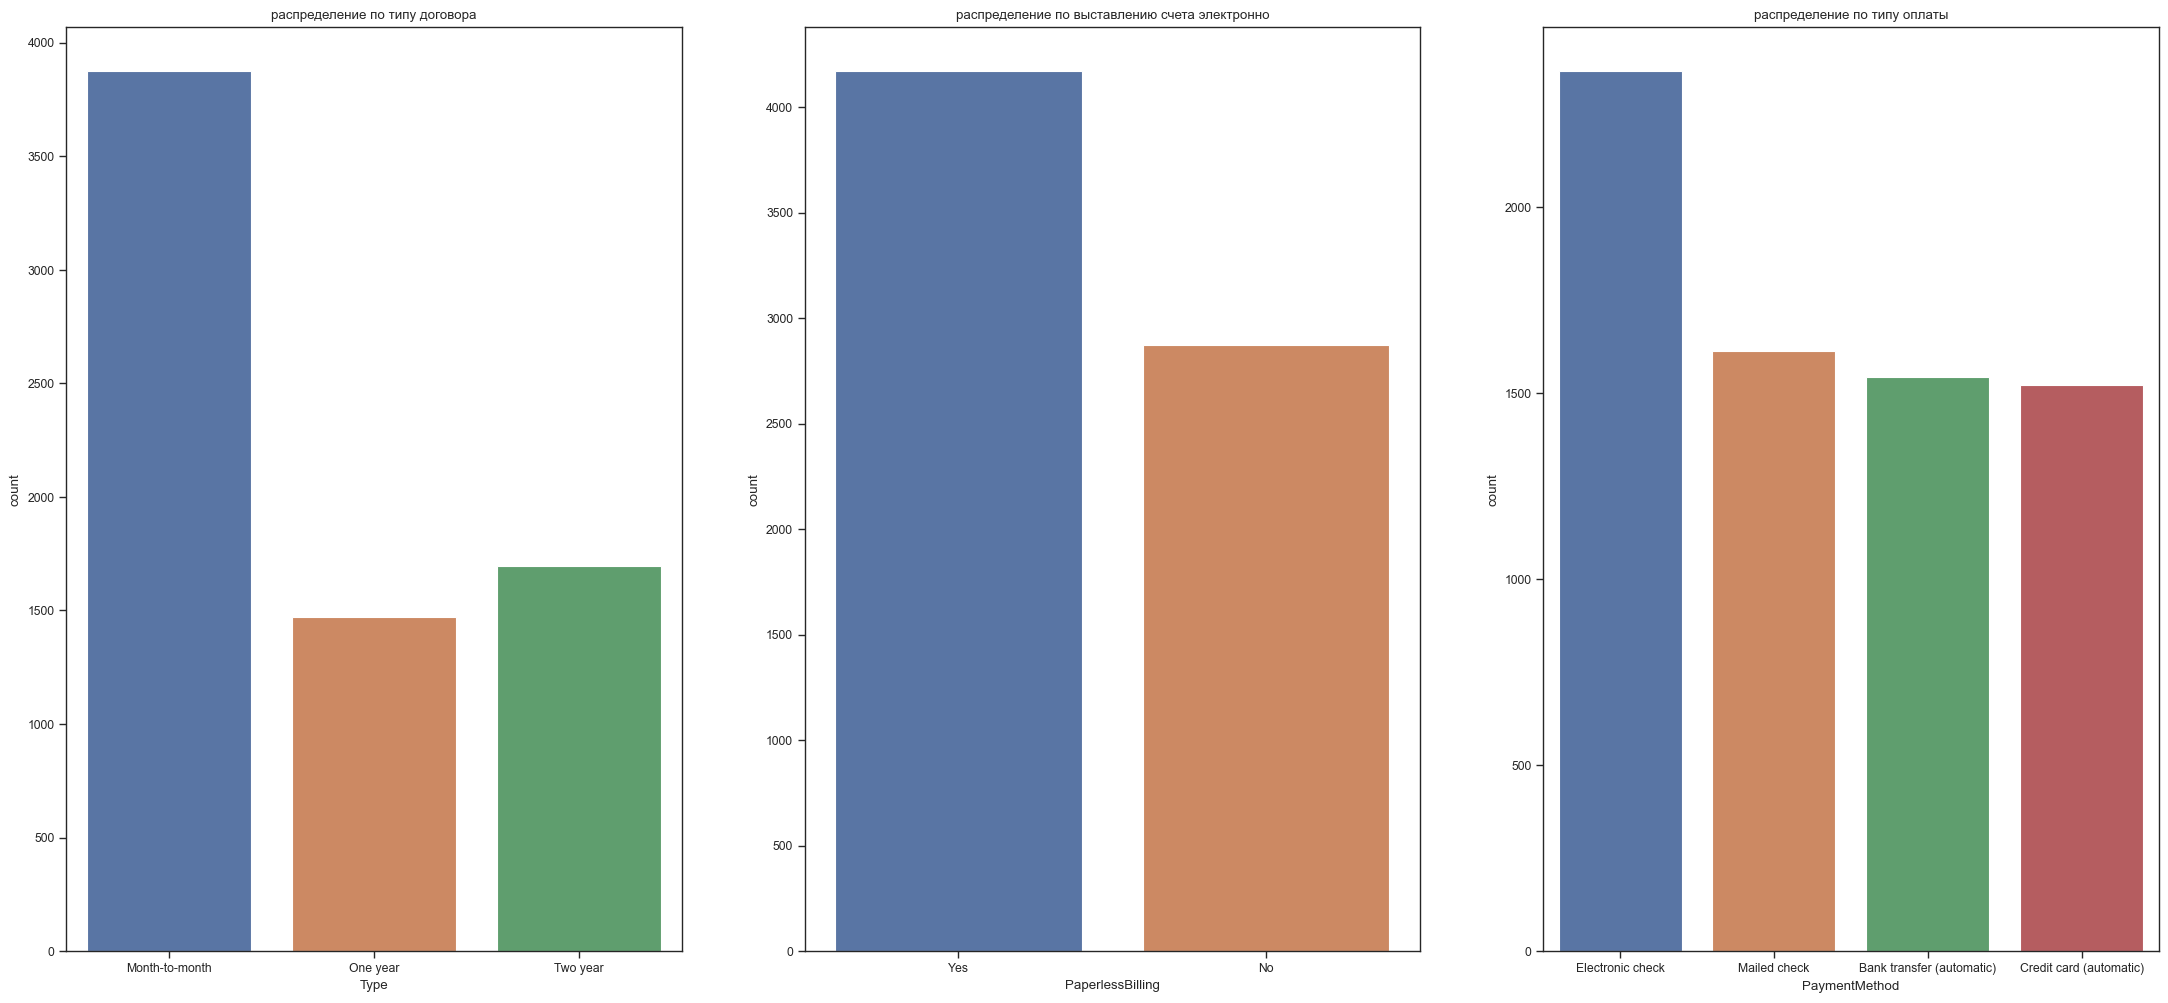

In [14]:
fig, ax =plt.subplots(1,3, figsize = (27,12))
sns.countplot(x="Type", data=contract_df, ax=ax[0]).set_title('распределение по типу договора')
sns.countplot(x="PaperlessBilling", data=contract_df, ax=ax[1]).set_title('распределение по выставлению счета электронно')
sns.countplot(x="PaymentMethod", data=contract_df, ax=ax[2]).set_title('распределение по типу оплаты')
fig.show()

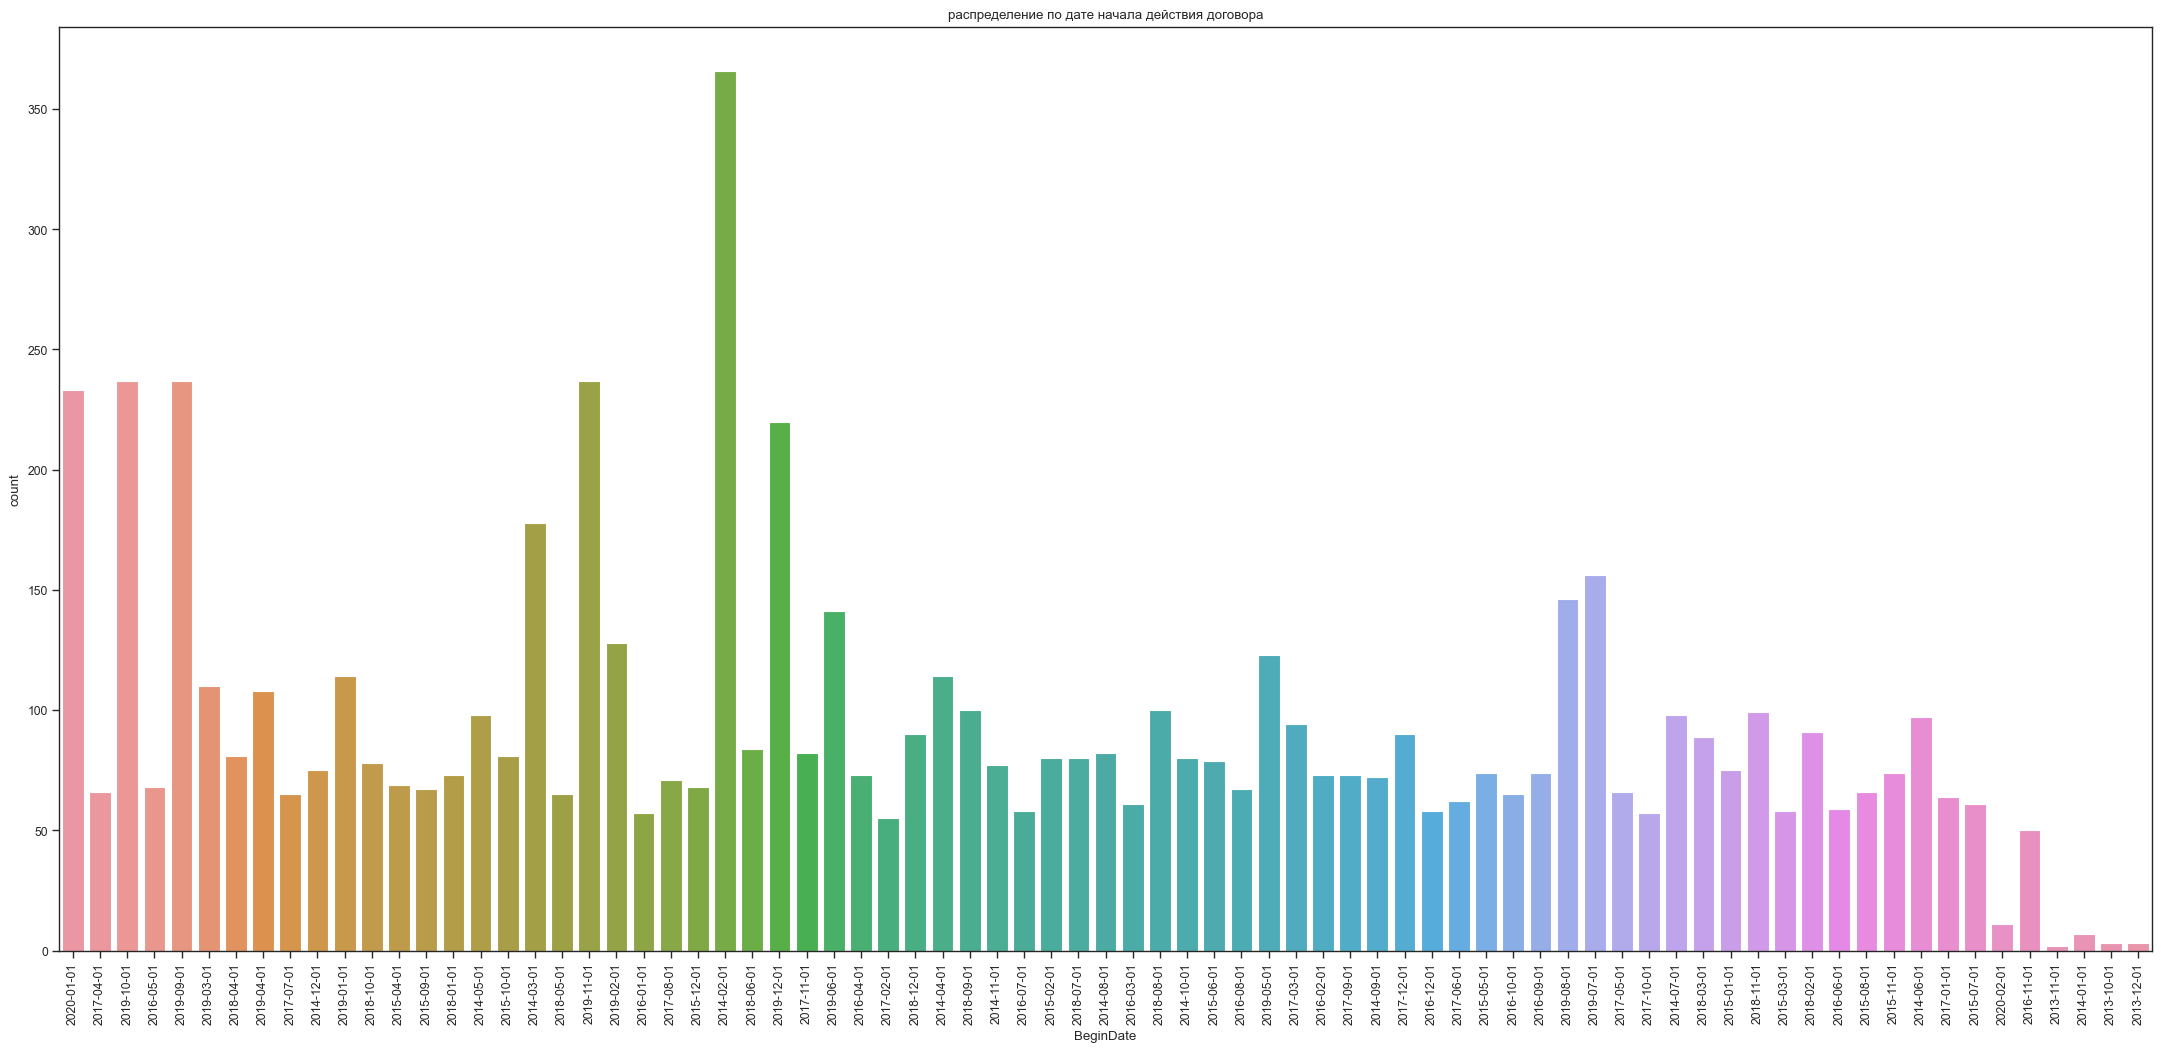

In [15]:
fig, ax =plt.subplots(figsize = (27,12))
ax.tick_params(axis='x', rotation=90)
sns.countplot(x="BeginDate", data=contract_df).set_title('распределение по дате начала действия договора')
fig.show()

In [16]:
yes_count = 0
no_count = 0
for i in contract_df['EndDate']:
    if i == "No":
        no_count +=1
    elif i != "No":
        yes_count +=1

In [17]:
print('cоотношение целевого класса(столбец EndDate):\nпроцент ушедших клиентов - ',
      round(yes_count/len(contract_df['EndDate']*100),2), '%', 
      '\nпроцент оставшихся клиентов - ', round(no_count/len(contract_df['EndDate']*100),2), '%')

cоотношение целевого класса(столбец EndDate):
процент ушедших клиентов -  0.16 % 
процент оставшихся клиентов -  0.84 %


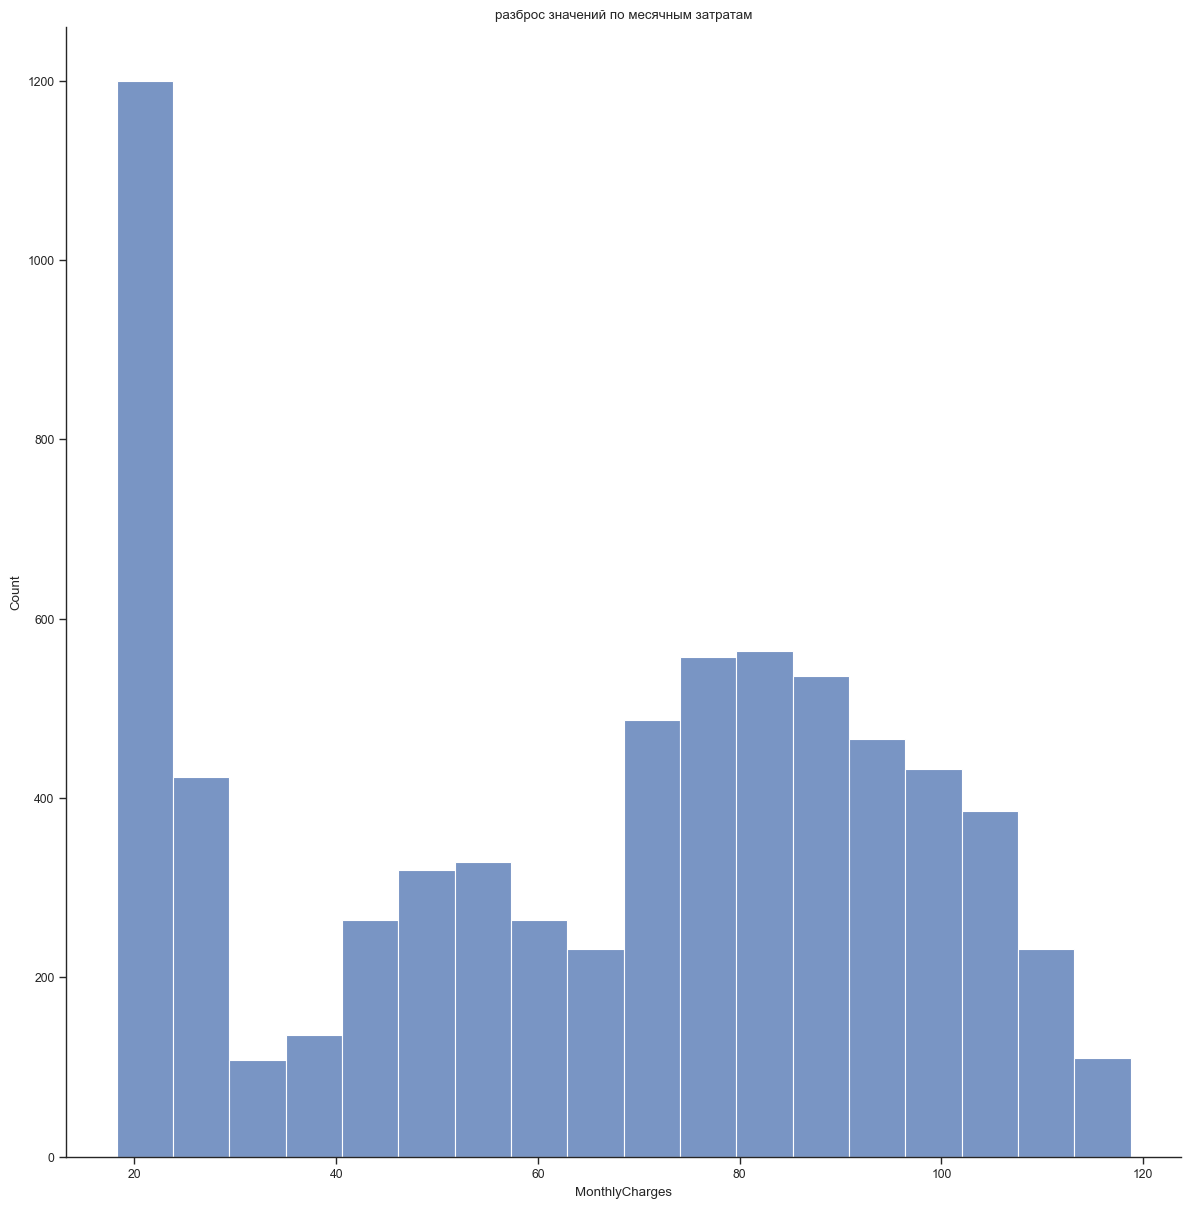

In [18]:

sns.displot(x="MonthlyCharges", data=contract_df,height=12,aspect=1)
plt.title("разброс значений по месячным затратам")
fig.show()

визуально посмотрим, что за клиенты платят ежемесячно меньше 30 у.е.

In [19]:
contract_df[contract_df['MonthlyCharges'] < 30]

customerID   BeginDate     EndDate            Type PaperlessBilling  \
0     7590-VHVEG  2020-01-01          No  Month-to-month              Yes   
7     6713-OKOMC  2019-04-01          No  Month-to-month               No   
11    7469-LKBCI  2018-10-01          No        Two year               No   
16    8191-XWSZG  2015-10-01          No        One year               No   
21    1680-VDCWW  2019-02-01          No        One year               No   
22    1066-JKSGK  2019-11-01          No  Month-to-month               No   
33    7310-EGVHZ  2020-01-01          No  Month-to-month               No   
42    9867-JCZSP  2018-09-01          No        One year               No   
58    3957-SQXML  2017-04-01          No        Two year               No   
68    3170-NMYVV  2015-12-01          No        Two year               No   
71    0731-EBJQB  2015-10-01          No        One year              Yes   
73    8028-PNXHQ  2014-12-01          No        Two year              Yes   
79    3887-PBQAO  2016-05-01  2017-09-01        One year              Yes   
84    0318-ZOPWS  2016-01-01          No        Two year              Yes   
87    1862-QRWPE  2016-02-01          No        Two year               No   
88    2796-NNUFI  2016-04-01          No        Two year              Yes   
97    0278-YXOOG  2019-06-01          No  Month-to-month               No   
98    3212-KXOCR  2015-10-01          No        Two year               No   
100   6380-ARCEH  2020-01-01          No  Month-to-month               No   
101   3679-XASPY  2020-01-01          No  Month-to-month               No   
105   6180-YBIQI  2019-09-01          No  Month-to-month               No   
109   2848-YXSMW  2014-02-01  2018-06-01        Two year               No   
118   8402-OOOHJ  2016-09-01          No        Two year               No   
121   2928-HLDBA  2019-08-01          No  Month-to-month               No   
124   7219-TLZHO  2019-10-01          No  Month-to-month               No   
127   6734-PSBAW  2014-02-01          No        Two year              Yes   
128   3930-ZGWVE  2020-01-01          No  Month-to-month               No   
135   7799-LGRDP  2016-07-01          No        Two year              Yes   
137   3774-VBNXY  2014-10-01  2020-01-01        Two year               No   
138   6217-KDYWC  2015-05-01          No        Two year              Yes   
144   1131-QQZEB  2014-03-01          No        Two year               No   
146   6837-BJYDQ  2019-11-01          No        One year               No   
154   3077-RSNTJ  2019-08-01          No  Month-to-month               No   
157   2749-CTKAJ  2018-04-01          No        One year               No   
159   7554-NEWDD  2019-04-01          No        Two year               No   
164   2907-ILJBN  2019-03-01          No        One year               No   
165   6345-FZOQH  2014-05-01  2015-06-01        Two year               No   
169   1159-WFSGR  2018-10-01          No  Month-to-month               No   
174   5918-VUKWP  2017-06-01          No        One year               No   
175   1744-JHKYS  2017-04-01          No  Month-to-month               No   
179   3712-PKXZA  2015-01-01  2019-04-01        One year              Yes   
180   6317-YPKDH  2019-12-01          No  Month-to-month               No   
185   1024-GUALD  2019-10-01          No  Month-to-month              Yes   
188   0956-SYCWG  2019-01-01          No        One year               No   
192   2984-RGEYA  2014-05-01          No        Two year               No   
194   2146-EGVDT  2015-03-01          No        Two year               No   
196   9178-JHUVJ  2018-02-01          No        Two year              Yes   
199   3645-DEYGF  2020-01-01          No  Month-to-month               No   
211   4195-NZGTA  2020-01-01          No  Month-to-month               No   
212   7157-SMCFK  2015-01-01  2017-08-01        Two year               No   
213   4709-LKHYG  2017-09-01          No        One year               No   
22

### анализ данных по персональным данным клиентов (personal_df)

- personal_new.csv - персональные данные клиента
    - gender - пол
    - SeniorCitizen - наличие пенсионного статуса по возрасту
    - Partner - наличие супруга/супруги
    - Dependents - наличие иждивенцев

In [20]:
get_data_info(personal_df)

количество строк и столбцов: (7043, 5)


customerID  gender  SeniorCitizen Partner Dependents
1965  3948-XHGNA    Male              0      No         No
4556  3750-CKVKH    Male              0      No         No
257   6655-LHBYW    Male              0      No         No
6609  1000-AJSLD    Male              0      No         No
2569  8237-ULIXL  Female              0     Yes         No

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     7043 non-null   object
 1   gender         7043 non-null   object
 2   SeniorCitizen  7043 non-null   int64 
 3   Partner        7043 non-null   object
 4   Dependents     7043 non-null   object
dtypes: int64(1), object(4)
memory usage: 275.2+ KB


customerID gender  SeniorCitizen Partner Dependents
count         7043   7043    7043.000000    7043       7043
unique        7043      2            NaN       2          2
top     7590-VHVEG   Male            NaN      No         No
freq             1   3555            NaN    3641       4933
mean           NaN    NaN       0.162147     NaN        NaN
std            NaN    NaN       0.368612     NaN        NaN
min            NaN    NaN       0.000000     NaN        NaN
25%            NaN    NaN       0.000000     NaN        NaN
50%            NaN    NaN       0.000000     NaN        NaN
75%            NaN    NaN       0.000000     NaN        NaN
max            NaN    NaN       1.000000     NaN        NaN

количество дубликатов: 0
количество пропусков:
 customerID       0
gender           0
SeniorCitizen    0
Partner          0
Dependents       0
dtype: int64


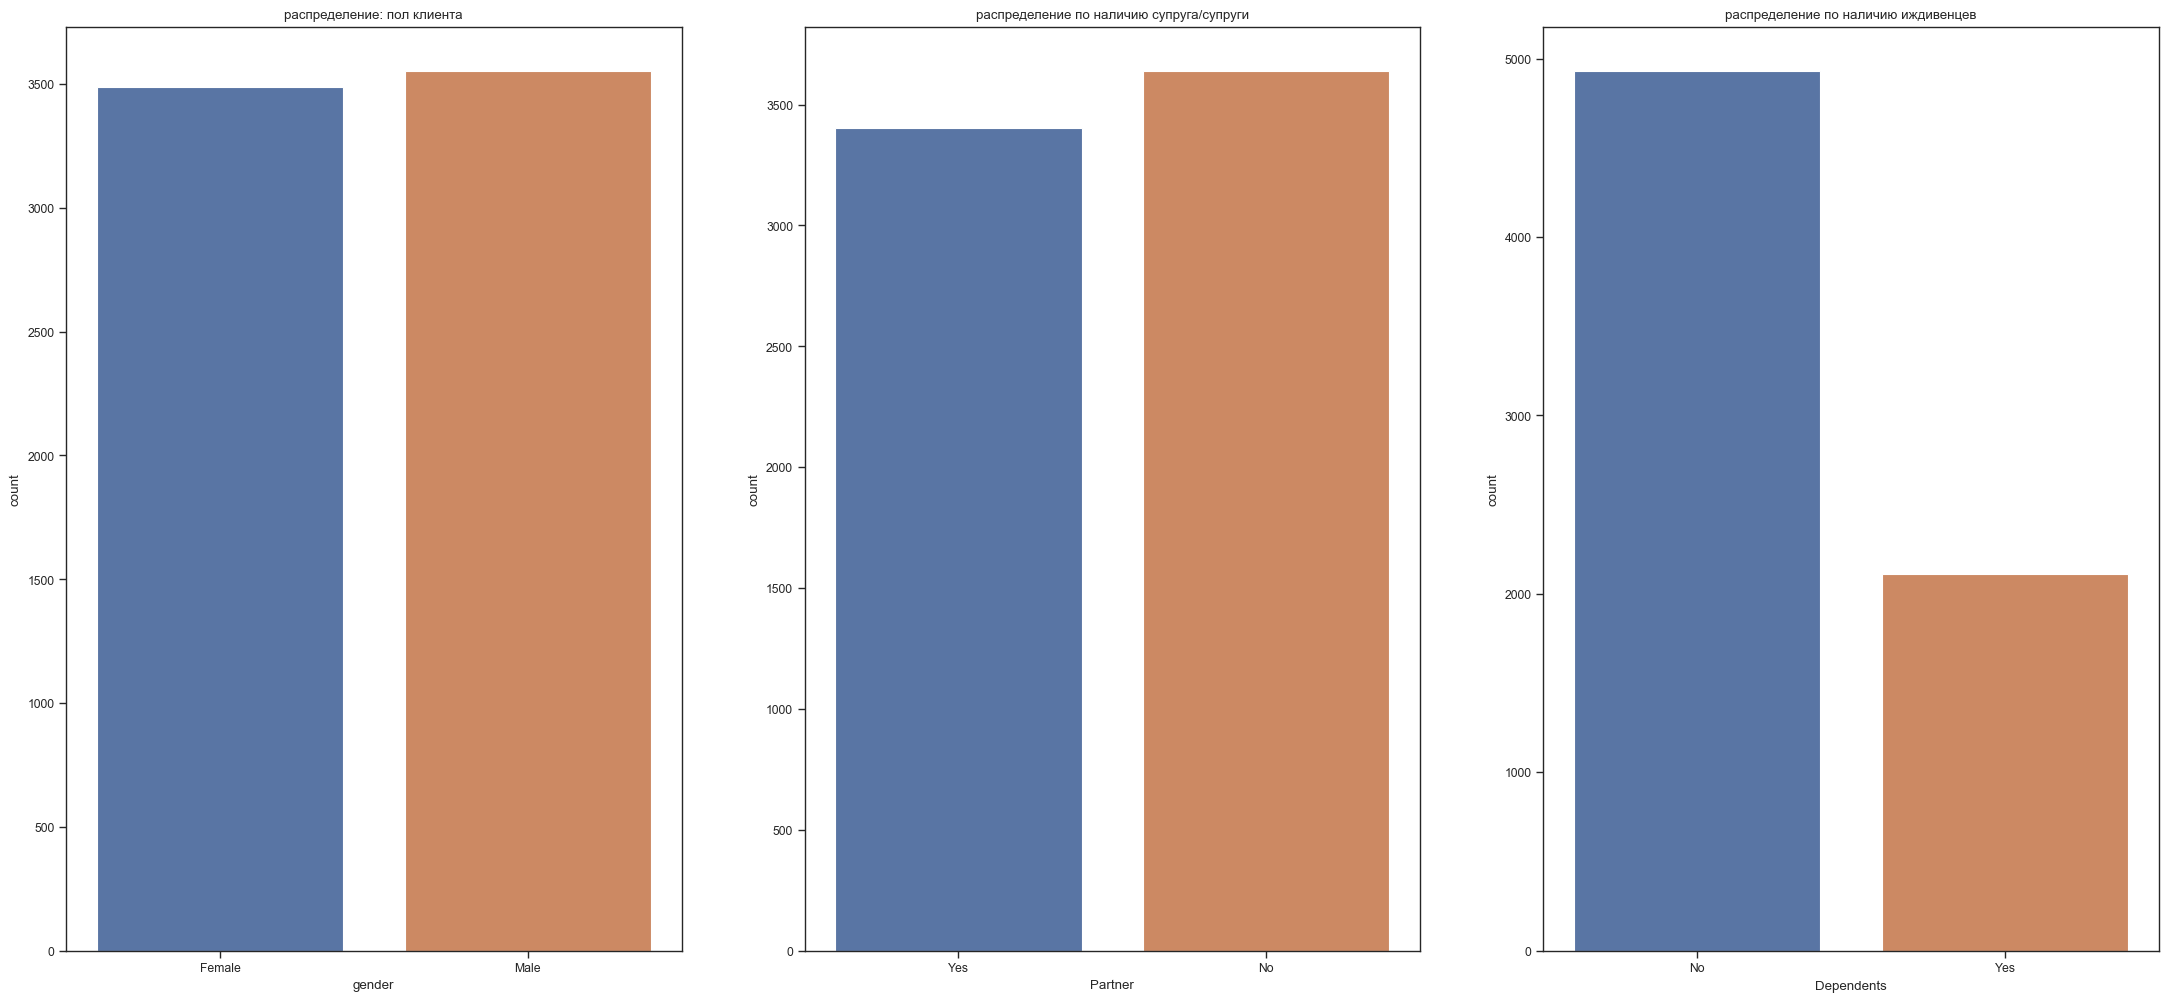

In [21]:
fig, ax =plt.subplots(1,3, figsize = (27,12))
sns.countplot(x="gender", data=personal_df, ax=ax[0]).set_title('распределение: пол клиента')
sns.countplot(x="Partner", data=personal_df, ax=ax[1]).set_title('распределение по наличию супруга/супруги')
sns.countplot(x="Dependents", data=personal_df, ax=ax[2]).set_title('распределение по наличию иждивенцев')
fig.show()

In [22]:
personal_df['SeniorCitizen'].value_counts()

0    5901
1    1142
Name: SeniorCitizen, dtype: int64

### анализ данных по информации об интернет-услугах (internet_df)

 - internet_new.csv - информация об интернет-услугах
    - InternetService - наличие услуг Интернет
    - OnlineSecurity - межсетевой экран
    - OnlineBackup - облачное хранилище файлов для резервного копирования данных
    - DeviceProtection - антивирус
    - TechSupport - выделенная линия технической поддержки
    - StreamingTV - онлайн-ТВ
    - StreamingMovies - онлайн-кинотеатр

In [23]:
get_data_info(internet_df)

количество строк и столбцов: (5517, 8)


customerID InternetService OnlineSecurity OnlineBackup DeviceProtection  \
3117  1334-FJSVR             DSL             No           No               No   
1923  8314-DPQHL             DSL            Yes           No              Yes   
1425  4816-LXZYW     Fiber optic             No          Yes               No   
5467  6967-PEJLL             DSL            Yes           No              Yes   
1710  1895-QTKDO             DSL             No           No               No   

     TechSupport StreamingTV StreamingMovies  
3117          No          No              No  
1923         Yes          No             Yes  
1425          No          No              No  
5467         Yes          No              No  
1710          No          No              No

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 0 to 5516
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   customerID        5517 non-null   object
 1   InternetService   5517 non-null   object
 2   OnlineSecurity    5517 non-null   object
 3   OnlineBackup      5517 non-null   object
 4   DeviceProtection  5517 non-null   object
 5   TechSupport       5517 non-null   object
 6   StreamingTV       5517 non-null   object
 7   StreamingMovies   5517 non-null   object
dtypes: object(8)
memory usage: 344.9+ KB


customerID InternetService OnlineSecurity OnlineBackup  \
count         5517            5517           5517         5517   
unique        5517               2              2            2   
top     7590-VHVEG     Fiber optic             No           No   
freq             1            3096           3498         3088   

       DeviceProtection TechSupport StreamingTV StreamingMovies  
count              5517        5517        5517            5517  
unique                2           2           2               2  
top                  No          No          No              No  
freq               3095        3473        2810            2785

количество дубликатов: 0
количество пропусков:
 customerID          0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
dtype: int64


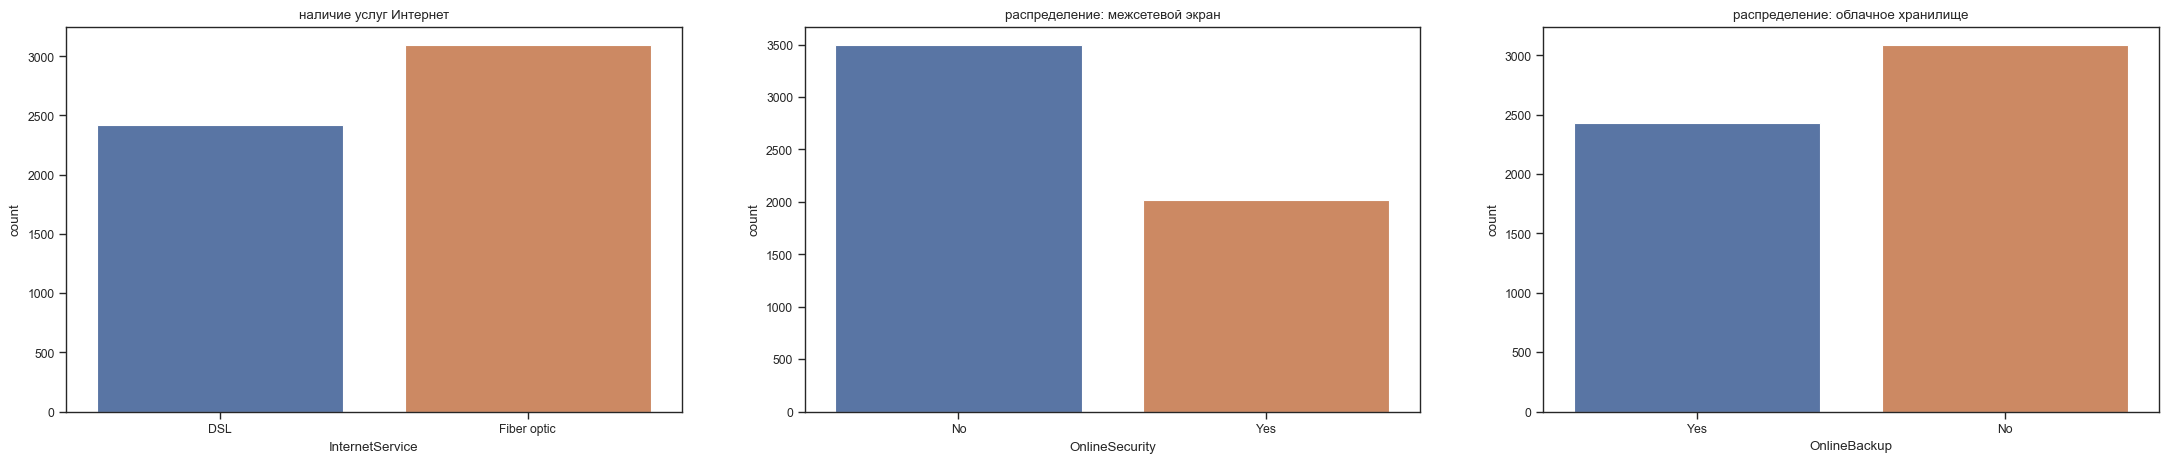

In [24]:
fig, ax =plt.subplots(1,3, figsize = (27,5))
sns.countplot(x="InternetService", data=internet_df, ax=ax[0]).set_title('наличие услуг Интернет')
sns.countplot(x="OnlineSecurity", data=internet_df, ax=ax[1]).set_title('распределение: межсетевой экран')
sns.countplot(x="OnlineBackup", data=internet_df, ax=ax[2]).set_title('распределение: облачное хранилище')
fig.show()

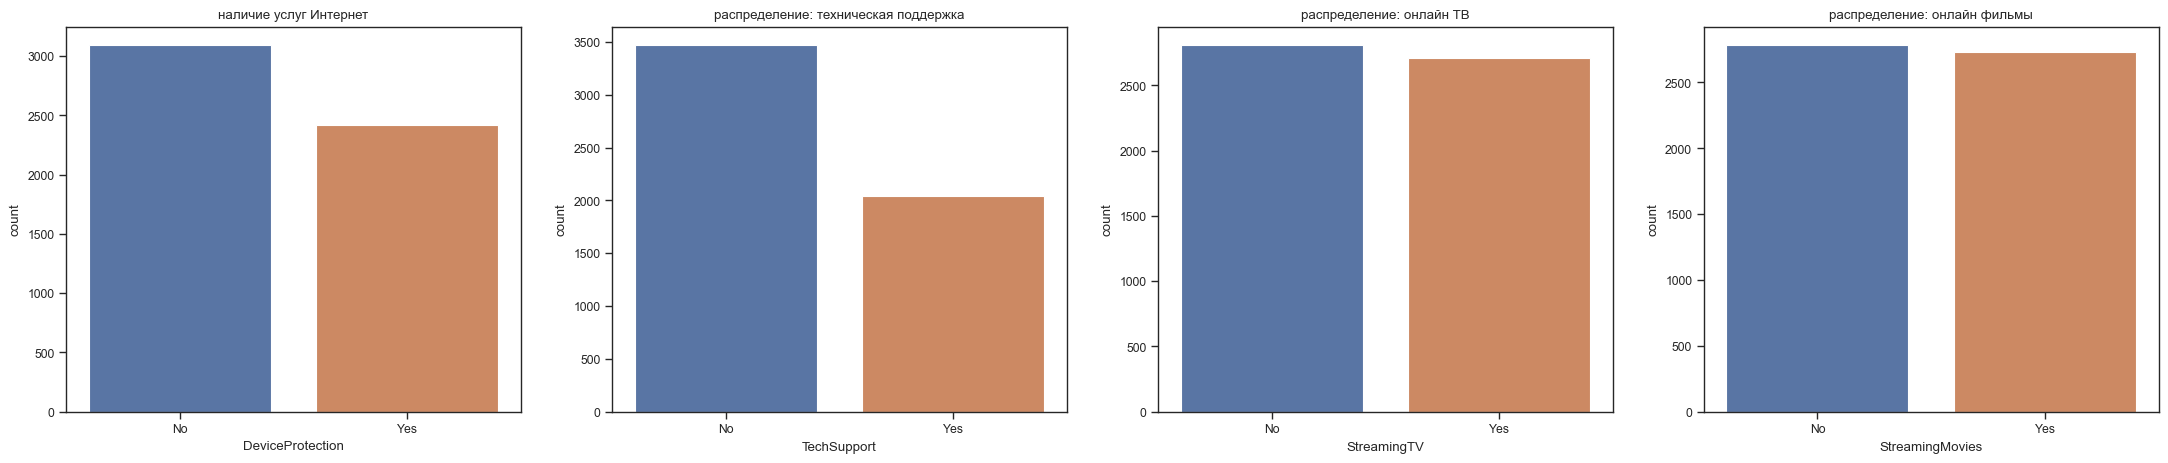

In [25]:
fig, ax =plt.subplots(1,4, figsize = (27,5))
sns.countplot(x="DeviceProtection", data=internet_df, ax=ax[0]).set_title('наличие услуг Интернет')
sns.countplot(x="TechSupport", data=internet_df, ax=ax[1]).set_title('распределение: техническая поддержка')
sns.countplot(x="StreamingTV", data=internet_df, ax=ax[2]).set_title('распределение: онлайн ТВ')
sns.countplot(x="StreamingMovies", data=internet_df, ax=ax[3]).set_title('распределение: онлайн фильмы')
fig.show()

### анализ данных по информации об услугах телефонии (phone_df)

 - phone_new.csv - информация об услугах телефонии
    - MultipleLines - возможность подключения телефонного аппарата к нескольким линиям одновременно

In [26]:
get_data_info(phone_df)

количество строк и столбцов: (6361, 2)


customerID MultipleLines
5867  0939-EREMR            No
4424  0899-LIIBW           Yes
2482  0244-LGNFY           Yes
1451  6485-QXWWE           Yes
5504  0401-WDBXM           Yes

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6361 entries, 0 to 6360
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     6361 non-null   object
 1   MultipleLines  6361 non-null   object
dtypes: object(2)
memory usage: 99.5+ KB


customerID MultipleLines
count         6361          6361
unique        6361             2
top     5575-GNVDE            No
freq             1          3390

количество дубликатов: 0
количество пропусков:
 customerID       0
MultipleLines    0
dtype: int64


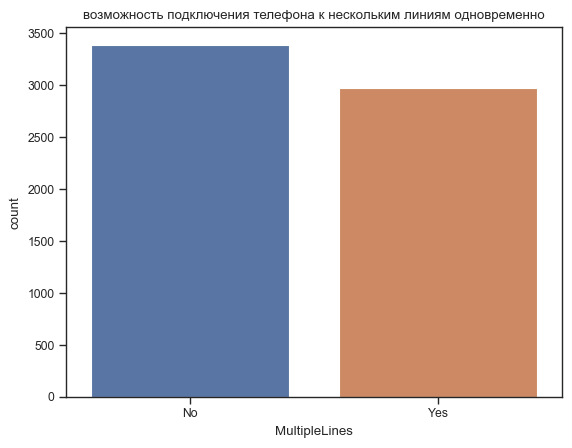

In [27]:

sns.countplot(x="MultipleLines", data=phone_df).set_title('возможность подключения телефона к нескольким линиям одновременно')

fig.show()

## Объединение данных

Сперва объединим датасеты с одинаковым количеством строк, потом остальные присоединим через outer  
после объединения проверим количество строк и столбцов

In [28]:
print(contract_df.shape,
personal_df.shape,
internet_df.shape,
phone_df.shape)

(7043, 8) (7043, 5) (5517, 8) (6361, 2)


In [29]:
df = contract_df.merge(personal_df, left_on = 'customerID', right_on='customerID', how='outer')

In [30]:
df.shape

(7043, 12)

In [31]:
df = df.merge(phone_df, left_on = 'customerID', right_on='customerID', how='outer')

In [32]:
df.shape

(7043, 13)

In [33]:
df = df.merge(internet_df, left_on = 'customerID', right_on='customerID', how='outer')

In [34]:
df.shape

(7043, 20)

In [35]:
get_data_info(df)

количество строк и столбцов: (7043, 20)


customerID   BeginDate EndDate            Type PaperlessBilling  \
4966  3097-IDVPU  2018-07-01      No  Month-to-month               No   
2427  7854-FOKSF  2019-12-01      No  Month-to-month               No   
1879  3494-JCHRQ  2019-12-01      No  Month-to-month              Yes   
6495  7254-IQWOZ  2019-09-01      No  Month-to-month              Yes   
3140  7901-HXJVA  2018-12-01      No  Month-to-month               No   

                PaymentMethod  MonthlyCharges TotalCharges gender  \
4966  Credit card (automatic)           50.10        951.9   Male   
2427         Electronic check           35.90         71.8   Male   
1879         Electronic check           70.05        144.3   Male   
6495         Electronic check           69.65       351.73   Male   
3140         Electronic check           76.45      1102.41   Male   

      SeniorCitizen Partner Dependents MultipleLines InternetService  \
4966              0     Yes        Yes           Yes             DSL   
2427              0      No         No           NaN             DSL   
1879              0      No         No            No     Fiber optic   
6495              0      No         No            No     Fiber optic   
3140              0      No         No            No     Fiber optic   

     OnlineSecurity OnlineBackup DeviceProtection TechSupport StreamingTV  \
4966             No           No               No          No          No   
2427             No           No               No          No          No   
1879             No           No               No          No          No   
6495             No           No               No          No          No   
3140             No           No              Yes          No          No   

     StreamingMovies  
4966              No  
2427             Yes  
1879              No  
6495              No  
3140              No

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   object 
 8   gender            7043 non-null   object 
 9   SeniorCitizen     7043 non-null   int64  
 10  Partner           7043 non-null   object 
 11  Dependents        7043 non-null   object 
 12  MultipleLines     6361 non-null   object 
 13  InternetService   5517 non-null   object 
 14  OnlineSecurity    5517 non-null   object 
 15  OnlineBackup      5517 non-null   object 
 16  DeviceProtection  5517 non-null   object 


customerID   BeginDate EndDate            Type PaperlessBilling  \
count         7043        7043    7043            7043             7043   
unique        7043          77      67               3                2   
top     7590-VHVEG  2014-02-01      No  Month-to-month              Yes   
freq             1         366    5942            3875             4171   
mean           NaN         NaN     NaN             NaN              NaN   
std            NaN         NaN     NaN             NaN              NaN   
min            NaN         NaN     NaN             NaN              NaN   
25%            NaN         NaN     NaN             NaN              NaN   
50%            NaN         NaN     NaN             NaN              NaN   
75%            NaN         NaN     NaN             NaN              NaN   
max            NaN         NaN     NaN             NaN              NaN   

           PaymentMethod  MonthlyCharges TotalCharges gender  SeniorCitizen  \
count               7043     7043.000000         7043   7043    7043.000000   
unique                 4             NaN         6658      2            NaN   
top     Electronic check             NaN                Male            NaN   
freq                2365             NaN           11   3555            NaN   
mean                 NaN       64.761692          NaN    NaN       0.162147   
std                  NaN       30.090047          NaN    NaN       0.368612   
min                  NaN       18.250000          NaN    NaN       0.000000   
25%                  NaN       35.500000          NaN    NaN       0.000000   
50%                  NaN       70.350000          NaN    NaN       0.000000   
75%                  NaN       89.850000          NaN    NaN       0.000000   
max                  NaN      118.750000          NaN    NaN       1.000000   

       Partner Dependents MultipleLines InternetService OnlineSecurity  \
count     7043       7043          6361            5517           5517   
unique       2          2             2               2              2   
top         No         No            No     Fiber optic             No   
freq      3641       4933          3390            3096           3498   
mean       NaN        NaN           NaN             NaN            NaN   
std        NaN        NaN           NaN             NaN            NaN   
min        NaN        NaN           NaN             NaN            NaN   
25%        NaN        NaN           NaN             NaN            NaN   
50%        NaN        NaN           NaN             NaN            NaN   
75%        NaN        NaN           NaN             NaN            NaN   
max        NaN        NaN           NaN             NaN            NaN   

       OnlineBackup DeviceProtection TechSupport StreamingTV StreamingMovies  
count          5517             5517        5517        5517            5517  
unique            2                2           2           2               2  
top              No               No          No          No              No  
freq           3088             3095        3473        2810            2785  
mean            NaN              NaN         NaN         NaN             NaN  
std             NaN              NaN         NaN         NaN             NaN  
min             NaN              NaN         NaN         NaN             NaN  
25%             NaN              NaN         NaN         NaN             NaN  
50%             NaN              NaN         NaN         NaN             NaN  
75%             NaN              NaN         NaN         NaN             NaN  
max             NaN              NaN         NaN         NaN             NaN

количество дубликатов: 0
количество пропусков:
 customerID             0
BeginDate              0
EndDate                0
Type                   0
PaperlessBilling       0
PaymentMethod          0
MonthlyCharges         0
TotalCharges           0
gender                 0
SeniorCitizen          0
Partner                0
Dependents             0
MultipleLines        682
InternetService     1526
OnlineSecurity      1526
OnlineBackup        1526
DeviceProtection    1526
TechSupport         1526
StreamingTV         1526
StreamingMovies     1526
dtype: int64


## Выделение целевого признака

Целевой признак выделим из столбца EndDate - создадим новый столбец, в котором присвоим 1 (клиент ушел), если значение в EndDate не равно No, если не ушел по состоянию на 2020-02-01 присвоим значение 0.

In [36]:
df["target"] = np.where(df["EndDate"]!='No', 1, 0)

In [37]:
#проверка

print('cоотношение целевого класса(столбец EndDate):\nпроцент ушедших клиентов - ',
      round(yes_count/len(contract_df['EndDate']*100),2), '%', 
      '\nпроцент оставшихся клиентов - ', round(no_count/len(contract_df['EndDate']*100),2), '%')

print("cоотношение целевого класса(столбец target):\n1 - клиент ушел, 0 - клиент остался")
print(df["target"].value_counts(normalize=True))

cоотношение целевого класса(столбец EndDate):
процент ушедших клиентов -  0.16 % 
процент оставшихся клиентов -  0.84 %
cоотношение целевого класса(столбец target):
1 - клиент ушел, 0 - клиент остался
0    0.843675
1    0.156325
Name: target, dtype: float64


## Исследование данных (разведочный анализ, EDA) для объединенных данных

Для построения матрицы корреляции переведем столбец TotalCharges в числовые значения, установим, что ошибкам присвоим значением NaN (при отработке выдает ошибку, что не может перевести некоторые строки в числовые данные), для себя отметим количество пропусков и в дальнейшем при обработке данных определимся - оставить NaN или вручную проанализировать ячейки с ошибками.


In [38]:
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')

In [39]:
print(df['TotalCharges'].isnull().sum().sum())

11



<image src="https://konspekta.net/mylektsiiru/baza12/3063428962180.files/image009.png" alt="Описание картинки">


Отметим уровни зависимости корреляции
![avatar](https://konspekta.net/mylektsiiru/baza12/3063428962180.files/image009.png)

In [40]:
interval_cols = ['MonthlyCharges', 'TotalCharges']
df_new = df.drop(['customerID'],axis=1)
phik_overview = df_new.phik_matrix(interval_cols=interval_cols)

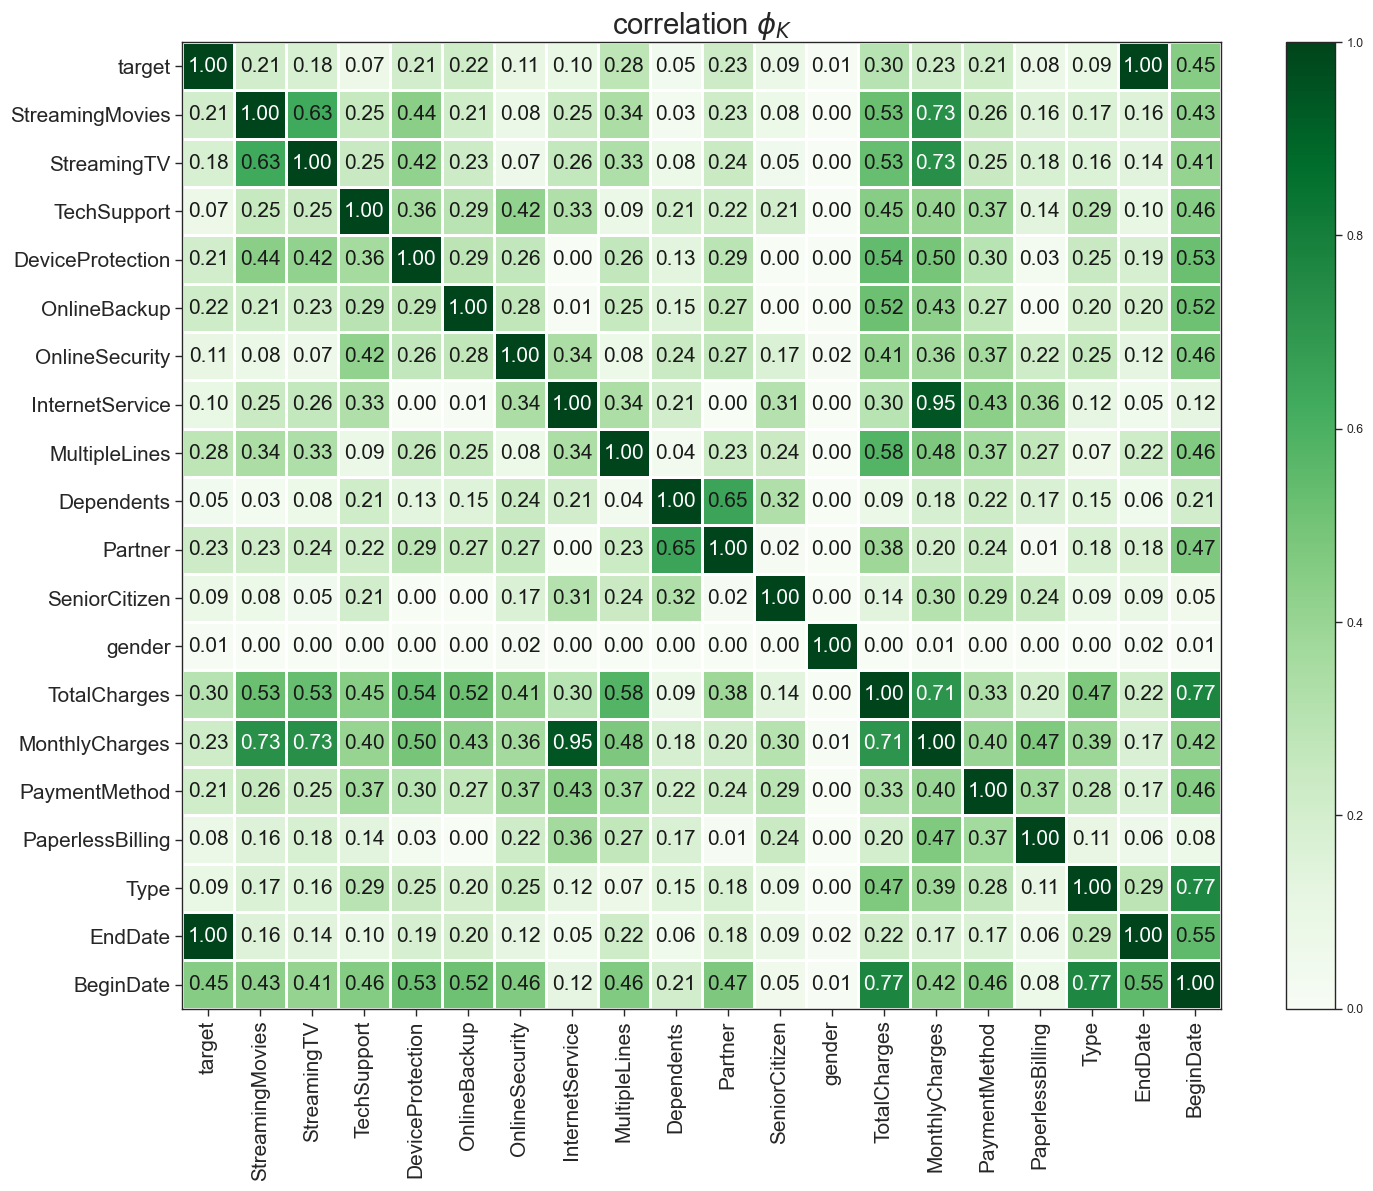

In [41]:

plot_correlation_matrix(phik_overview.values, 
                        x_labels=phik_overview.columns, 
                        y_labels=phik_overview.index, 
                        vmin=0, vmax=1, color_map="Greens", 
                        title=r"correlation $\phi_K$", 
                        fontsize_factor=1.5, 
                        figsize=(15, 12))
plt.tight_layout()

влияние "числовых" данных друг на друга в размере целевой переменной

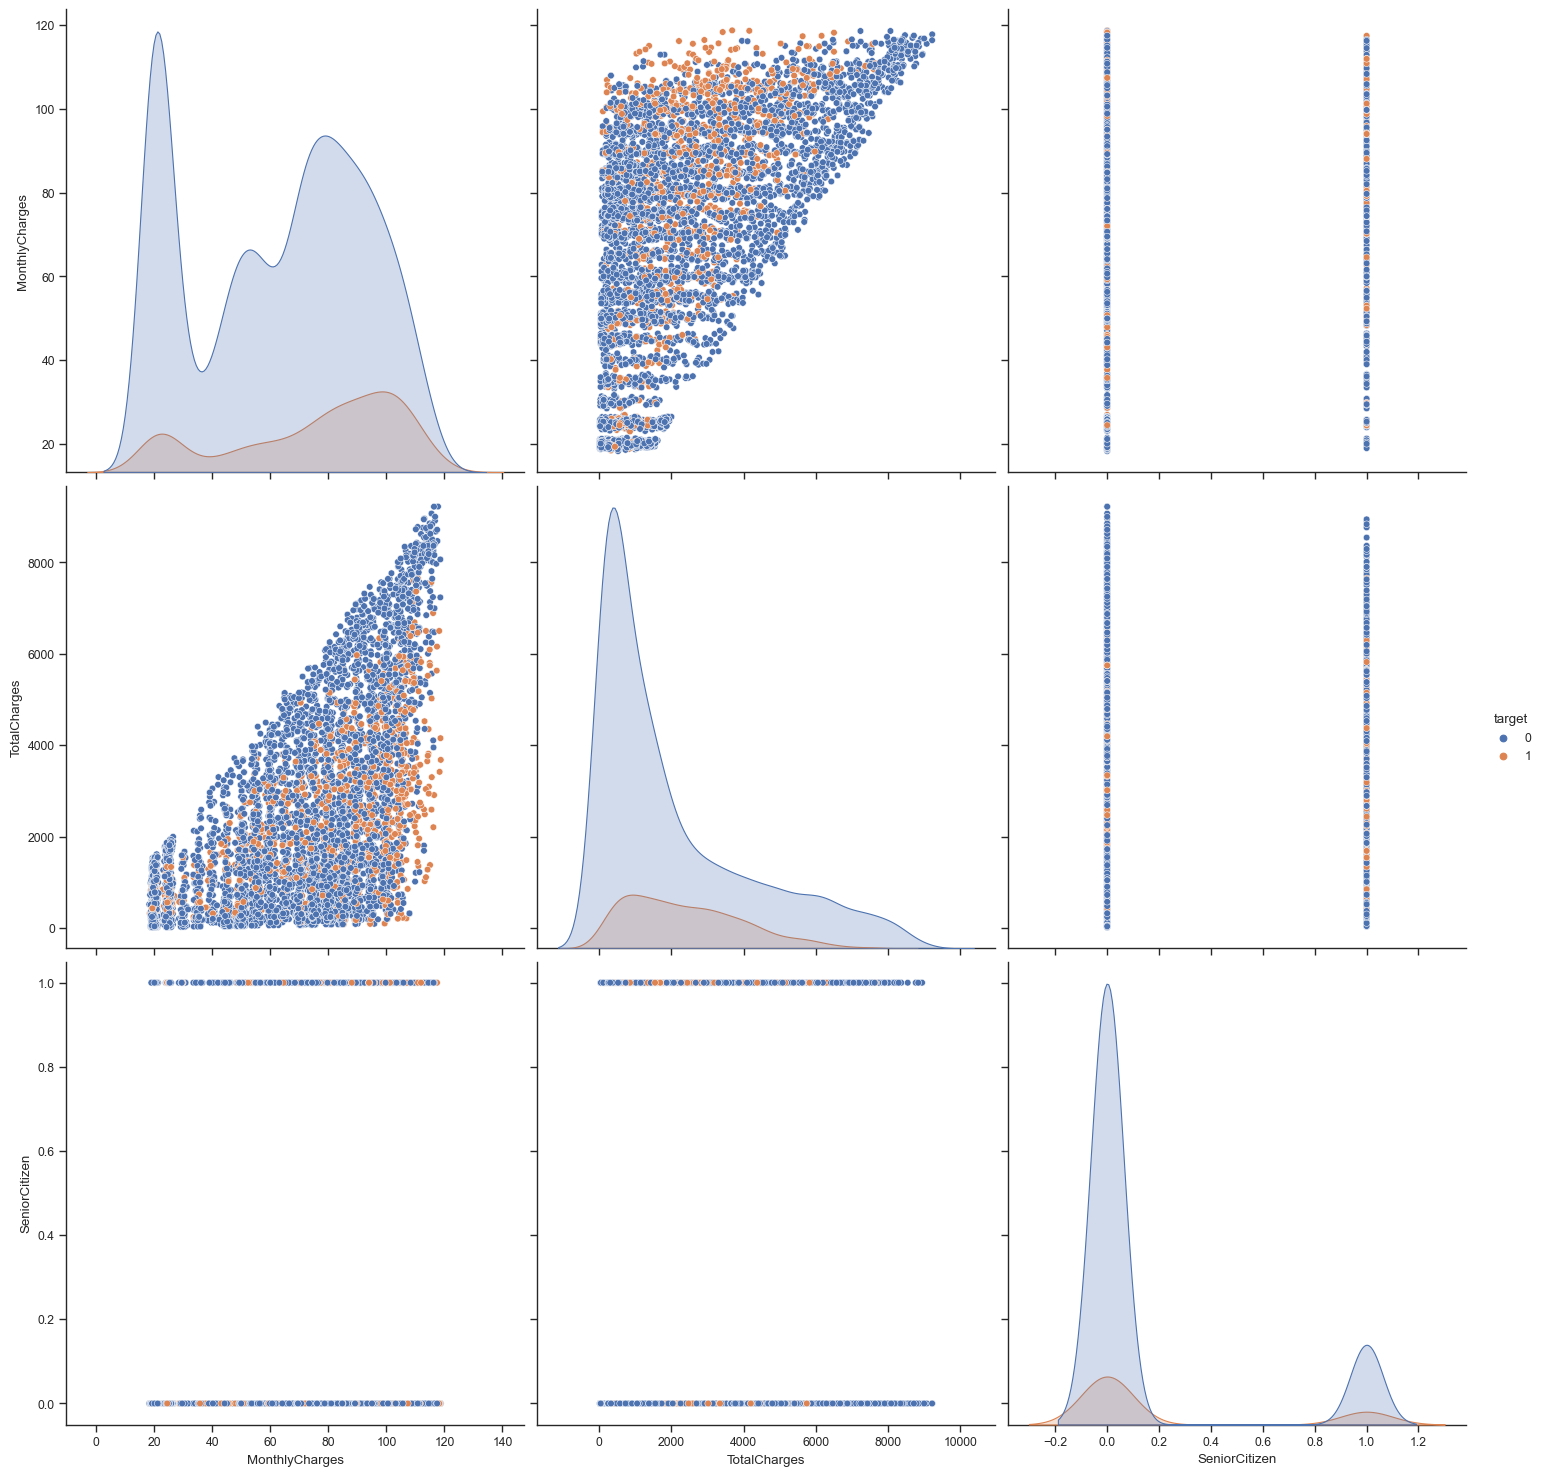

In [42]:

sns.pairplot(df, hue='target', height=5)
fig.show()

Разброс наиболее сильно влиющих на таргет переменных в разбивке по количеству значений для каждого класса (0 или 1) таргета

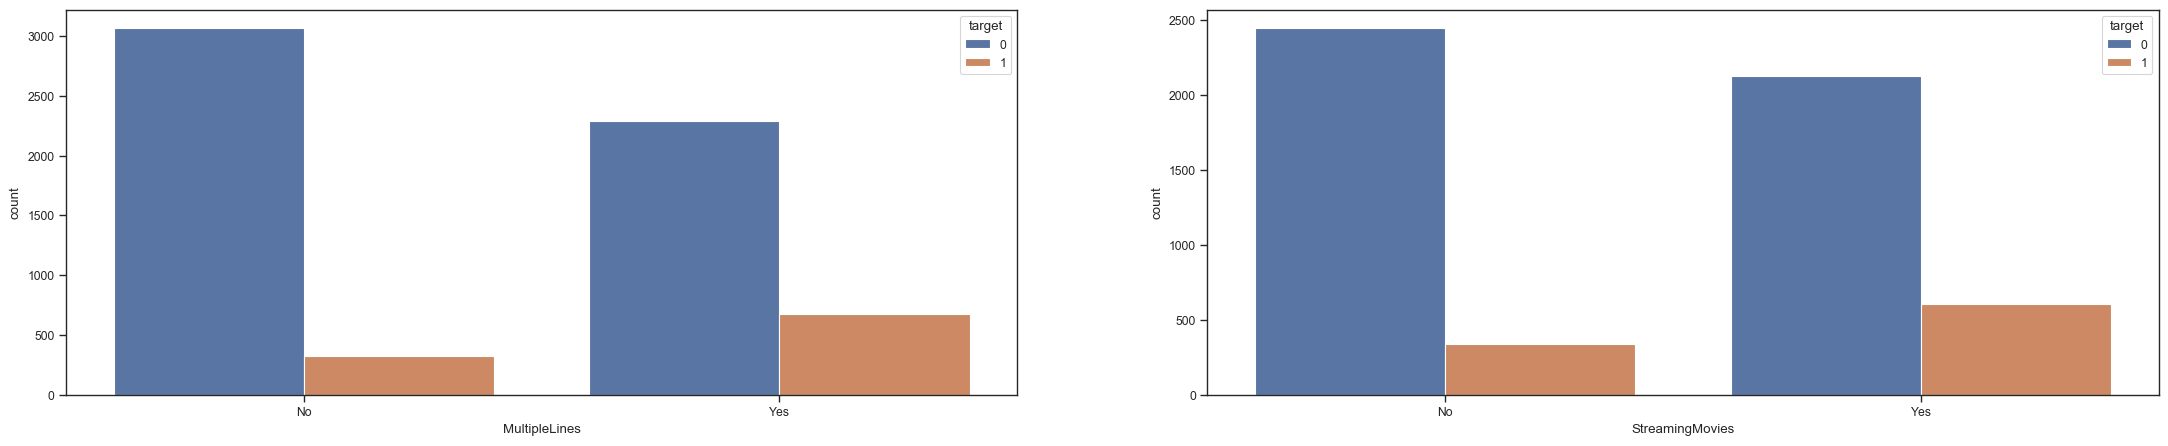

In [43]:
fig, ax =plt.subplots(1,2, figsize = (27,5))
sns.countplot(x ='MultipleLines', hue = "target", data = df, ax=ax[0])
sns.countplot(x ='StreamingMovies', hue = "target", data = df, ax=ax[1])
fig.show()

Рассмотрим на графике параметры, что сильно влияют друг на друга - вид интернет услуги (DSL или Fiber optic) на ежемесячные затраты - по матрице корреляции получилась очень сильная зависимость

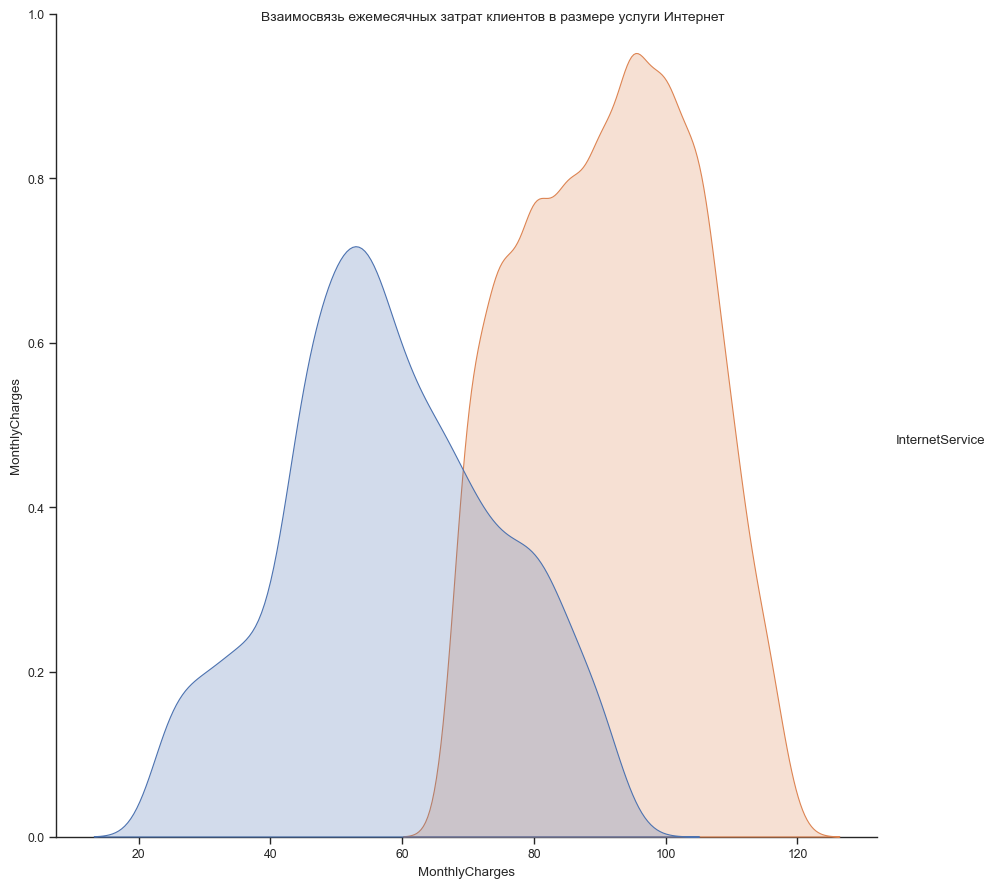

In [44]:
g5 = sns.pairplot(df, vars=['MonthlyCharges'], hue = 'InternetService', height = 9)
g5.fig.suptitle('Взаимосвязь ежемесячных затрат клиентов в размере услуги Интернет',
               fontsize = 10)

fig.show()

## Этапы обучения и контроль качества модели

## Предварительные выводы

**По итогам предварительного анализа дынных можно сделать такие наблюдения:** 
- ярко выражен дисбаланс классов таргета (16% и 84%), что потребует балансировки классов при разбиении на выборки и в параметрах моделей;
- есть зависимости между некоторыми величинами, что потребует удаления некоторых фичей для обеспечения качественной работы моделей;
- После объединения таблиц появилось много незаполненных значений (до ~ 1500 в некоторых столбцах), что потребует установки заглушек для работы моделей;
- довольно небольшой датасет, что потребует минимального удаления столбцов (только в случае сильного влияния), а также добавления синтечиских данных;
- Почти все параметры являются категориальными (кроме месячных и всего затрат);
- в части категориальных параметров не наблюдается сильных перевесов, кроме затрат на межсетевой экран и выделенную линию техподдержки (почти вдвое меньше людей пользуются этими услугами), а также в части наличия иждивенцов (больше клиентов указали, что нет)
- также можно отметить, что преобладающий платеж - ежемесячный, при этом есть порядка 1600 клиентов, которые платят меньше 30 у.е. (на графике можно увидеть самый большой пик в районе 20-30 у.е.) - при этом такие клиенты могут давно заключить контракты, так и не давно. В целом, предлагается не расценивать это как выброс, а как то, что клиенты не меняют тип оплаты и пользуются мнимальным количеством услуг (в основном, визуально можно отметить, что большинство услуг отмечены как No)

## Предобработка данных и разработка моделей

предварительные шаги по предобработке данных:  
- после объединения таблиц получили довольно много пропусков, скорее всего будет применена заглушка на NaN, чтобы модели отрабатывали и не удалять столбы.
- мы получили 11 дополнительных пропусков в столбце TotalCharges после перевода из object в numeric, так как пропусков мало, то дополнительный анализ проводится не будет
- будет удален столбец customerID - при построении матрицы корреляции столбец вносил 100% влияние на столбцы.
- EndDate и BeginDate привести к формату времени для вычислений  
- в столбце EndDate значение No будет заменено на "2020-02-01", далее будет удален столбец EndDate после фич инжениринга
- в столбце SeniorCitizen заменить 0 и 1 на Yes и No

ниже решаемые задачи по плану:

1. EndDate и BeginDate привести к формату времени для вычислений
2. в столбце EndDate значение No будет заменено на "2020-02-01", далее будет удален столбец EndDate после фич инжениринга
3. будет удален столбец customerID - при построении матрицы корреляции столбец вносил 100% влияние на столбцы.

In [45]:
df.loc[ df['EndDate'] == 'No', 'EndDate'] = '2020-02-01'

In [46]:
df['EndDate'].unique()

array(['2020-02-01', '2017-05-01', '2016-03-01', '2018-09-01',
       '2018-11-01', '2018-12-01', '2019-08-01', '2018-07-01',
       '2017-09-01', '2015-09-01', '2016-07-01', '2016-06-01',
       '2018-03-01', '2019-02-01', '2018-06-01', '2019-06-01',
       '2020-01-01', '2019-11-01', '2016-09-01', '2015-06-01',
       '2016-12-01', '2019-05-01', '2019-04-01', '2017-06-01',
       '2017-08-01', '2018-04-01', '2018-08-01', '2018-02-01',
       '2019-07-01', '2015-12-01', '2014-06-01', '2018-10-01',
       '2019-01-01', '2017-07-01', '2017-12-01', '2018-05-01',
       '2015-11-01', '2019-10-01', '2019-03-01', '2016-02-01',
       '2016-10-01', '2018-01-01', '2017-11-01', '2015-10-01',
       '2019-12-01', '2015-07-01', '2017-04-01', '2015-02-01',
       '2017-03-01', '2016-05-01', '2016-11-01', '2015-08-01',
       '2019-09-01', '2017-10-01', '2017-02-01', '2016-08-01',
       '2016-04-01', '2015-05-01', '2014-09-01', '2014-10-01',
       '2017-01-01', '2015-03-01', '2015-01-01', '2016-

In [47]:
df['EndDate'] = pd.to_datetime(
    df['EndDate'].str.strip(), format='%Y/%m/%d')

In [48]:
df['BeginDate'] = pd.to_datetime(
    df['BeginDate'].str.strip(), format='%Y/%m/%d')

In [49]:
# проверка по изменению типа данных
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   customerID        7043 non-null   object        
 1   BeginDate         7043 non-null   datetime64[ns]
 2   EndDate           7043 non-null   datetime64[ns]
 3   Type              7043 non-null   object        
 4   PaperlessBilling  7043 non-null   object        
 5   PaymentMethod     7043 non-null   object        
 6   MonthlyCharges    7043 non-null   float64       
 7   TotalCharges      7032 non-null   float64       
 8   gender            7043 non-null   object        
 9   SeniorCitizen     7043 non-null   int64         
 10  Partner           7043 non-null   object        
 11  Dependents        7043 non-null   object        
 12  MultipleLines     6361 non-null   object        
 13  InternetService   5517 non-null   object        
 14  OnlineSecurity    5517 n

In [50]:
df['days_between'] = (df["EndDate"] - df['BeginDate']) / np.timedelta64 ( 1 , 'D')

In [51]:
df['months_between'] = (df["EndDate"] - df['BeginDate']) / np.timedelta64 ( 1 , 'M')

In [52]:
df['years_between'] = (df["EndDate"] - df['BeginDate']) / np.timedelta64 ( 1 , 'Y')

In [53]:
#check
df.head(5)

customerID  BeginDate    EndDate            Type PaperlessBilling  \
0  7590-VHVEG 2020-01-01 2020-02-01  Month-to-month              Yes   
1  5575-GNVDE 2017-04-01 2020-02-01        One year               No   
2  3668-QPYBK 2019-10-01 2020-02-01  Month-to-month              Yes   
3  7795-CFOCW 2016-05-01 2020-02-01        One year               No   
4  9237-HQITU 2019-09-01 2020-02-01  Month-to-month              Yes   

               PaymentMethod  MonthlyCharges  TotalCharges  gender  \
0           Electronic check           29.85         31.04  Female   
1               Mailed check           56.95       2071.84    Male   
2               Mailed check           53.85        226.17    Male   
3  Bank transfer (automatic)           42.30       1960.60    Male   
4           Electronic check           70.70        353.50  Female   

   SeniorCitizen  ... OnlineSecurity OnlineBackup DeviceProtection  \
0              0  ...             No          Yes               No   
1              0  ...            Yes           No              Yes   
2              0  ...            Yes          Yes               No   
3              0  ...            Yes           No              Yes   
4              0  ...             No           No               No   

  TechSupport StreamingTV StreamingMovies target days_between months_between  \
0          No          No              No      0         31.0       1.018501   
1          No          No              No      0       1036.0      34.037660   
2          No          No              No      0        123.0       4.041151   
3         Yes          No              No      0       1371.0      45.044046   
4          No          No              No      0        153.0       5.026797   

  years_between  
0      0.084875  
1      2.836472  
2      0.336763  
3      3.753671  
4      0.418900  

[5 rows x 24 columns]

In [54]:
#котнрольная точка перед изменениями - удалениями и т.д. далее работаем с df_final
df_final = df.copy()

In [55]:
df_final = df_final.drop(['customerID', 'EndDate'], axis=1)

In [56]:
df_final.head(1)

BeginDate            Type PaperlessBilling     PaymentMethod  \
0 2020-01-01  Month-to-month              Yes  Electronic check   

   MonthlyCharges  TotalCharges  gender  SeniorCitizen Partner Dependents  \
0           29.85         31.04  Female              0     Yes         No   

   ... OnlineSecurity OnlineBackup DeviceProtection TechSupport StreamingTV  \
0  ...             No          Yes               No          No          No   

  StreamingMovies target days_between  months_between  years_between  
0              No      0         31.0        1.018501       0.084875  

[1 rows x 22 columns]

ниже задача по плану:  

- в столбце SeniorCitizen заменить 0 и 1 на Yes и No

In [57]:
df_final["SeniorCitizen"] = np.where(df_final["SeniorCitizen"]==1, 'Yes', 'No')

In [58]:
#check
print(personal_df['SeniorCitizen'].value_counts())
print(df_final['SeniorCitizen'].value_counts())

0    5901
1    1142
Name: SeniorCitizen, dtype: int64
No     5901
Yes    1142
Name: SeniorCitizen, dtype: int64


### Выделение целевого признака

- Целевой признак выделен выше, однако, в рамках данного пункта удалим столбец EndDate, оставив в df только один столбец с целевым признаком - target  
- также у нас наблюдается бисбаланс классов - поэтому применим class_weight='balanced' при построении моделей и при разбиении на выборки stratify=target

### Feature Engineering (Синтетические признаки)

некоторые идеи для создания новых паарметров:  
- вычислить время сколько клиент был (или остается) клиентом - EndDate - BeginDate - возможно в месяцах
- вычислить сколько сделал подписок клиент за время действия контракта
- выделить год подписки, месяц и день недели

в разделе 10.1 проведена сразу и обработка и создание новых столбцов, связанных со временем - столбцы с количеством дней, месяцев и лет сколько клиент пользовался услугами.

ниже представлены графики распределения затрат (общих и мксячных), а также введено два новых признака: общие затраты, поделенные на месячные затраты и общие затраты, поделенные на количество дней действия договора

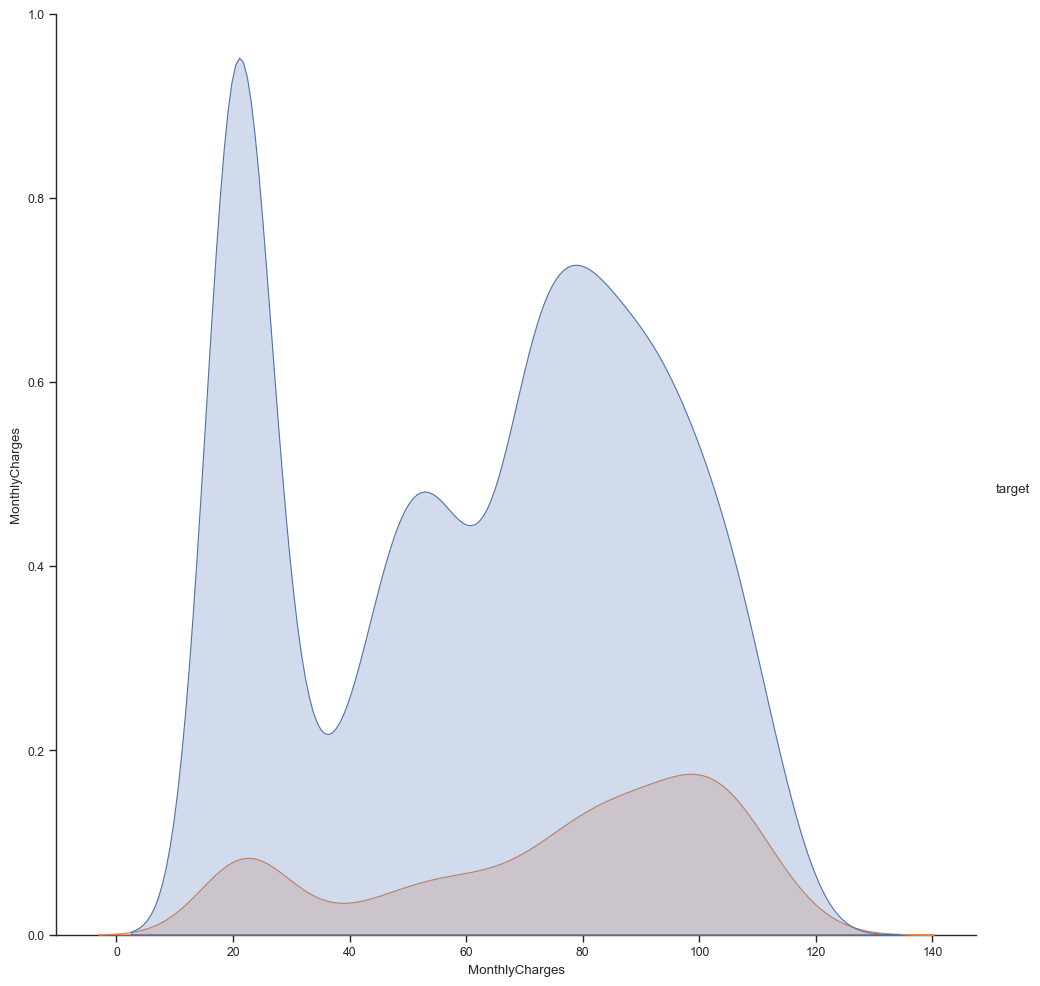

In [59]:
sns.pairplot(df_final, vars=['MonthlyCharges'], hue = 'target', height = 10)
fig.suptitle('Взаимосвязь ежемесячных затрат клиентов в разрезе таргета',
               fontsize = 10)

fig.show()

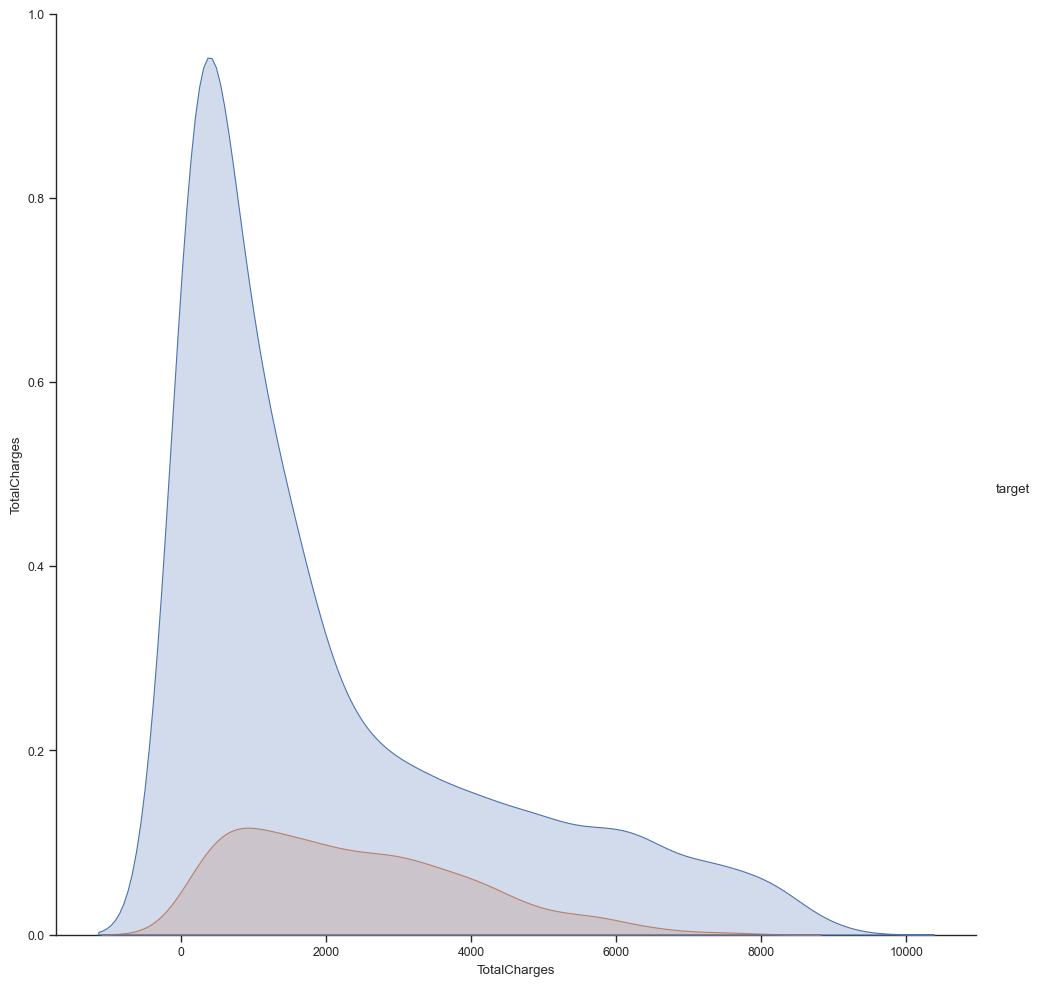

In [60]:
sns.pairplot(df_final, vars=['TotalCharges'], hue = 'target', height = 10)
fig.suptitle('Взаимосвязь ежемесячных затрат клиентов в разрезе таргета',
               fontsize = 10)

fig.show()

In [61]:
df_final['Chargespermonth'] = df_final['TotalCharges'] / df_final['MonthlyCharges']

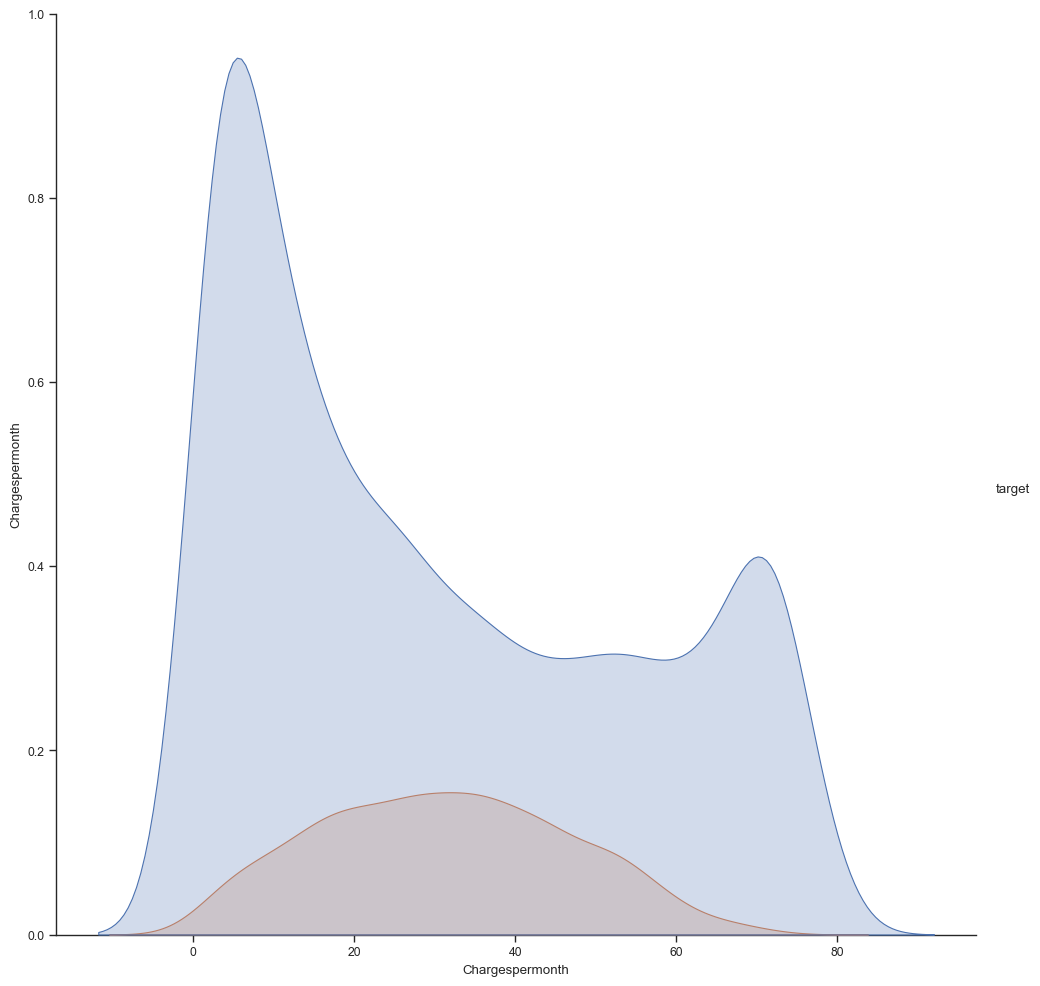

In [62]:
sns.pairplot(df_final, vars=['Chargespermonth'], hue = 'target', height = 10)
fig.suptitle('Взаимосвязь ежемесячных затрат клиентов в разрезе таргета',
               fontsize = 10)

fig.show()

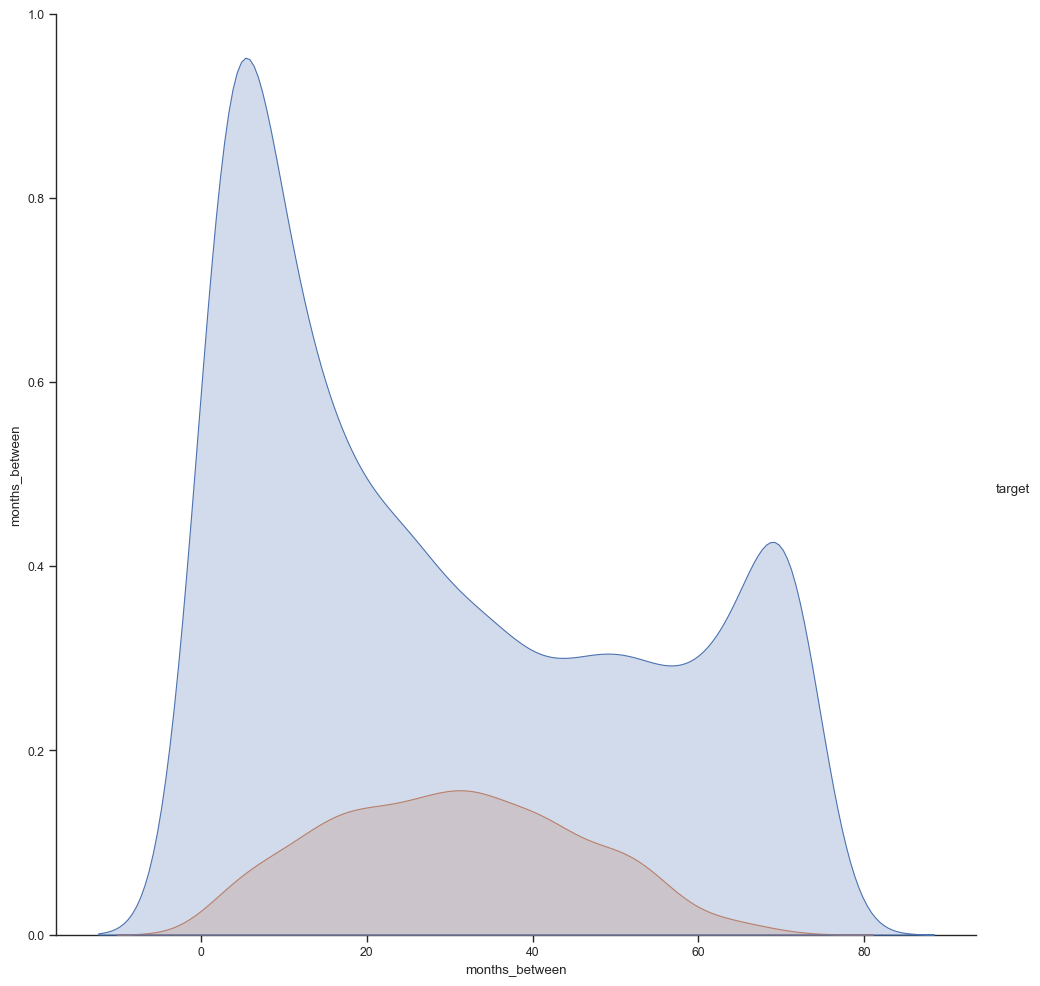

In [63]:
sns.pairplot(df_final, vars=['months_between'], hue = 'target', height = 10)
fig.suptitle('Взаимосвязь ежемесячных затрат клиентов в разрезе таргета',
               fontsize = 10)

fig.show()

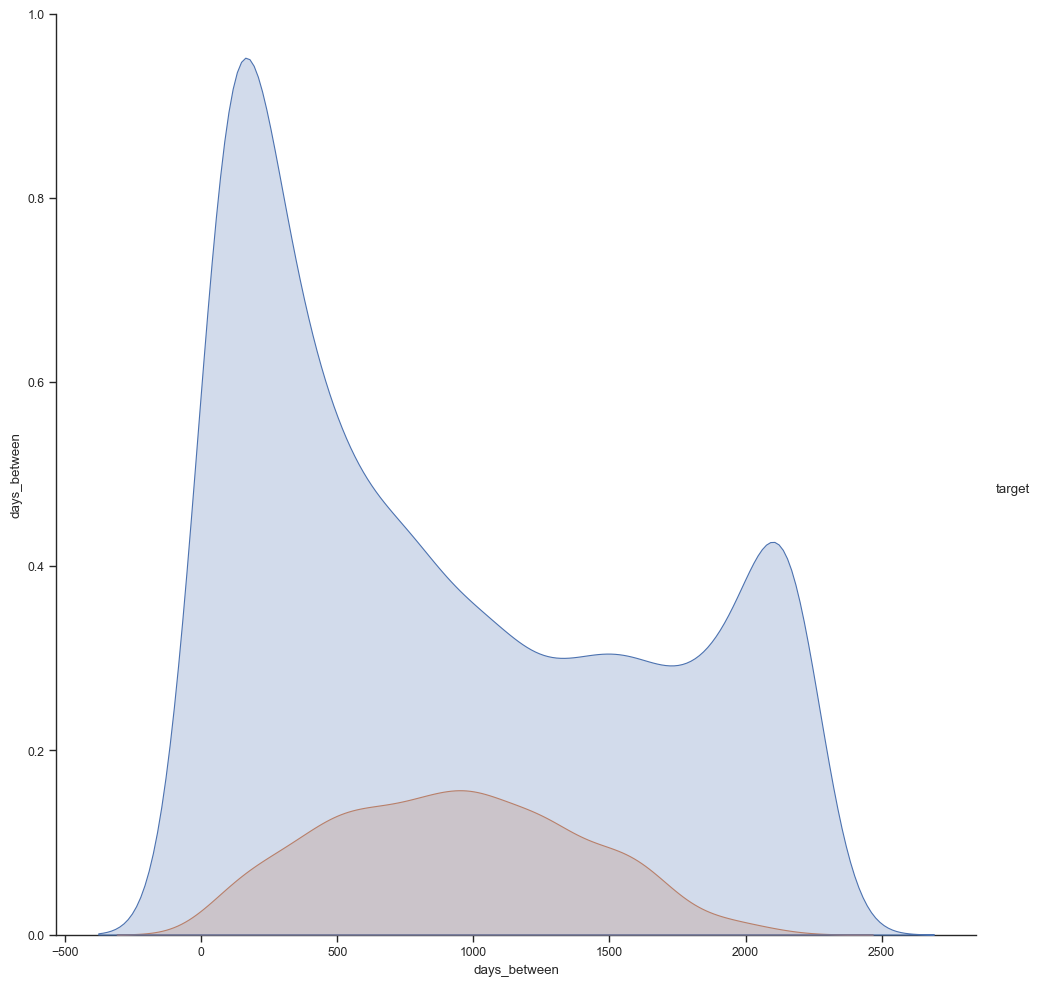

In [64]:
sns.pairplot(df_final, vars=['days_between'], hue = 'target', height = 10)
fig.suptitle('Взаимосвязь ежемесячных затрат клиентов в разрезе таргета',
               fontsize = 10)

fig.show()

In [65]:
df_final['Charges_days'] = df_final['TotalCharges'] / df_final['days_between']

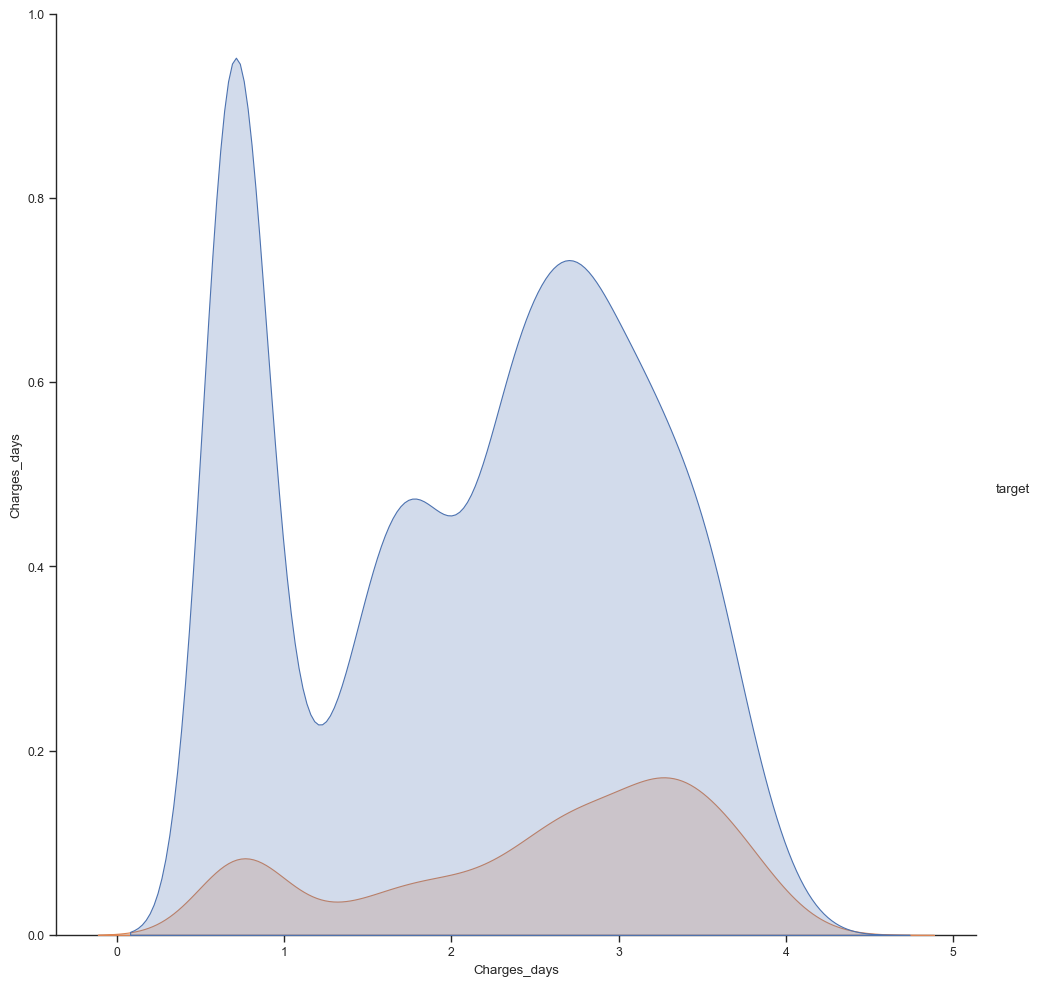

In [66]:
sns.pairplot(df_final, vars=['Charges_days'], hue = 'target', height = 10)
fig.suptitle('Взаимосвязь ежемесячных затрат клиентов в разрезе таргета',
               fontsize = 10)

fig.show()

In [67]:
df_final.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 24 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   BeginDate         7043 non-null   datetime64[ns]
 1   Type              7043 non-null   object        
 2   PaperlessBilling  7043 non-null   object        
 3   PaymentMethod     7043 non-null   object        
 4   MonthlyCharges    7043 non-null   float64       
 5   TotalCharges      7032 non-null   float64       
 6   gender            7043 non-null   object        
 7   SeniorCitizen     7043 non-null   object        
 8   Partner           7043 non-null   object        
 9   Dependents        7043 non-null   object        
 10  MultipleLines     6361 non-null   object        
 11  InternetService   5517 non-null   object        
 12  OnlineSecurity    5517 non-null   object        
 13  OnlineBackup      5517 non-null   object        
 14  DeviceProtection  5517 n

### Проверка корреляции с целевой переменной

в предварительном анализе вывел матрицу корреляции для датасета, в который не вносились изменения, дополнительно после всей предобработки, фич инжениринга и удаления столбца EndDate провеим корреляцию

In [68]:
integer_columns = df_final.select_dtypes(include=['int64', 'float64']).columns.drop('target')

In [69]:
phik_overview_final = df_final.phik_matrix(interval_cols=integer_columns)

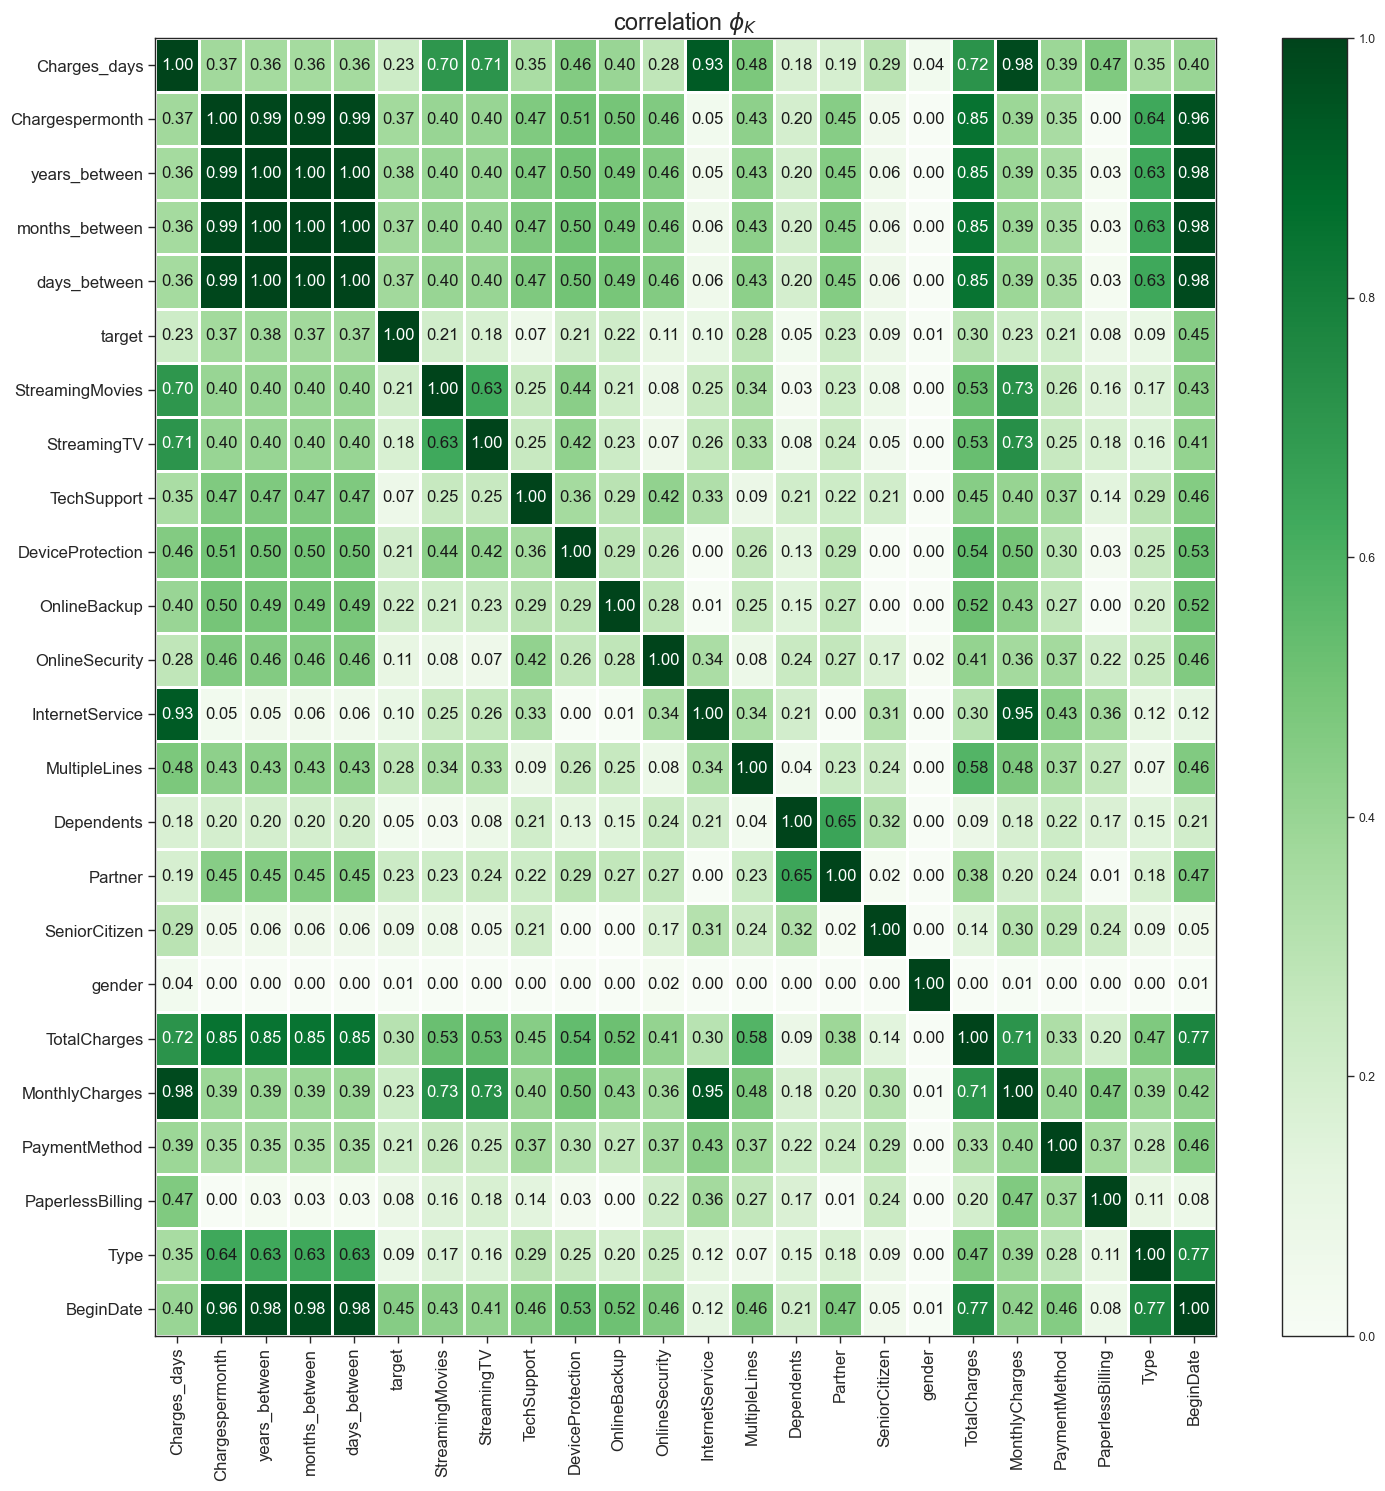

In [70]:

plot_correlation_matrix(phik_overview_final.values, 
                        x_labels=phik_overview_final.columns, 
                        y_labels=phik_overview_final.index, 
                        vmin=0, vmax=1, color_map="Greens", 
                        title=r"correlation $\phi_K$", 
                        fontsize_factor=1.2, 
                        figsize=(15, 15))
plt.tight_layout()

по матрице зависимостей видим, что созданные фичи (years_between, months_between, days_between) имеют интересный уровень зависимостей с другими фичами - умеренную, однако, друг с другом имеют очень сильное влияние, что может привести к преобучению моделей. В следующем пункте 10.4 будут описаны шаги для предотвращения мультиколлениарности и повторно рассмотренно влияение фичей. 

In [71]:
df_final_check = df_final.copy()

### предотвращение мультиколлениарности

после проверки корреляции - примем решение об удалении столбцов, которые сильно влияют друг на друга

- Удалим новые столбцы (years_between, months_between), оставим days_between. 
- Удалим столбцы Charges_days и Chargespermonth
- Удалим BeginDate, так как есть признак по количеству дней действия договора


Данные столбцы имеют сильное влияние друг на друга, но при этом их влияние на таргет выше многих первоначальных признаков, поэтому два синтетических признака оставим.


Что касается влияния MonthlyCharges, InternetService и MonthlyCharges - то так как мало в целом фичей, то данные признаки оставим и оценим влияние их на обучение, в случае необходимости данные признаки удалим.

In [72]:
df_final.columns

Index(['BeginDate', 'Type', 'PaperlessBilling', 'PaymentMethod',
       'MonthlyCharges', 'TotalCharges', 'gender', 'SeniorCitizen', 'Partner',
       'Dependents', 'MultipleLines', 'InternetService', 'OnlineSecurity',
       'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV',
       'StreamingMovies', 'target', 'days_between', 'months_between',
       'years_between', 'Chargespermonth', 'Charges_days'],
      dtype='object')

In [73]:
df_final = df_final.drop(['months_between','years_between', 'Charges_days','Chargespermonth', 'BeginDate'], axis=1)

In [74]:
#check
df_final.columns

Index(['Type', 'PaperlessBilling', 'PaymentMethod', 'MonthlyCharges',
       'TotalCharges', 'gender', 'SeniorCitizen', 'Partner', 'Dependents',
       'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup',
       'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies',
       'target', 'days_between'],
      dtype='object')

### Отбор признаков

Так как датасет небольшой по количеству строк, то будут удалены только столбцы с сильной корреляцией друг на друга (например, столбец EndDate и target). Также есть сильная зависимость между столбцами MonthlyCharges и InternetService - необходимо также будет изучить влияние этих столбцов на итоговые показатели моделей.

ниже представлена матрица корреляции признаков, которые будут использованы для обучения моделей

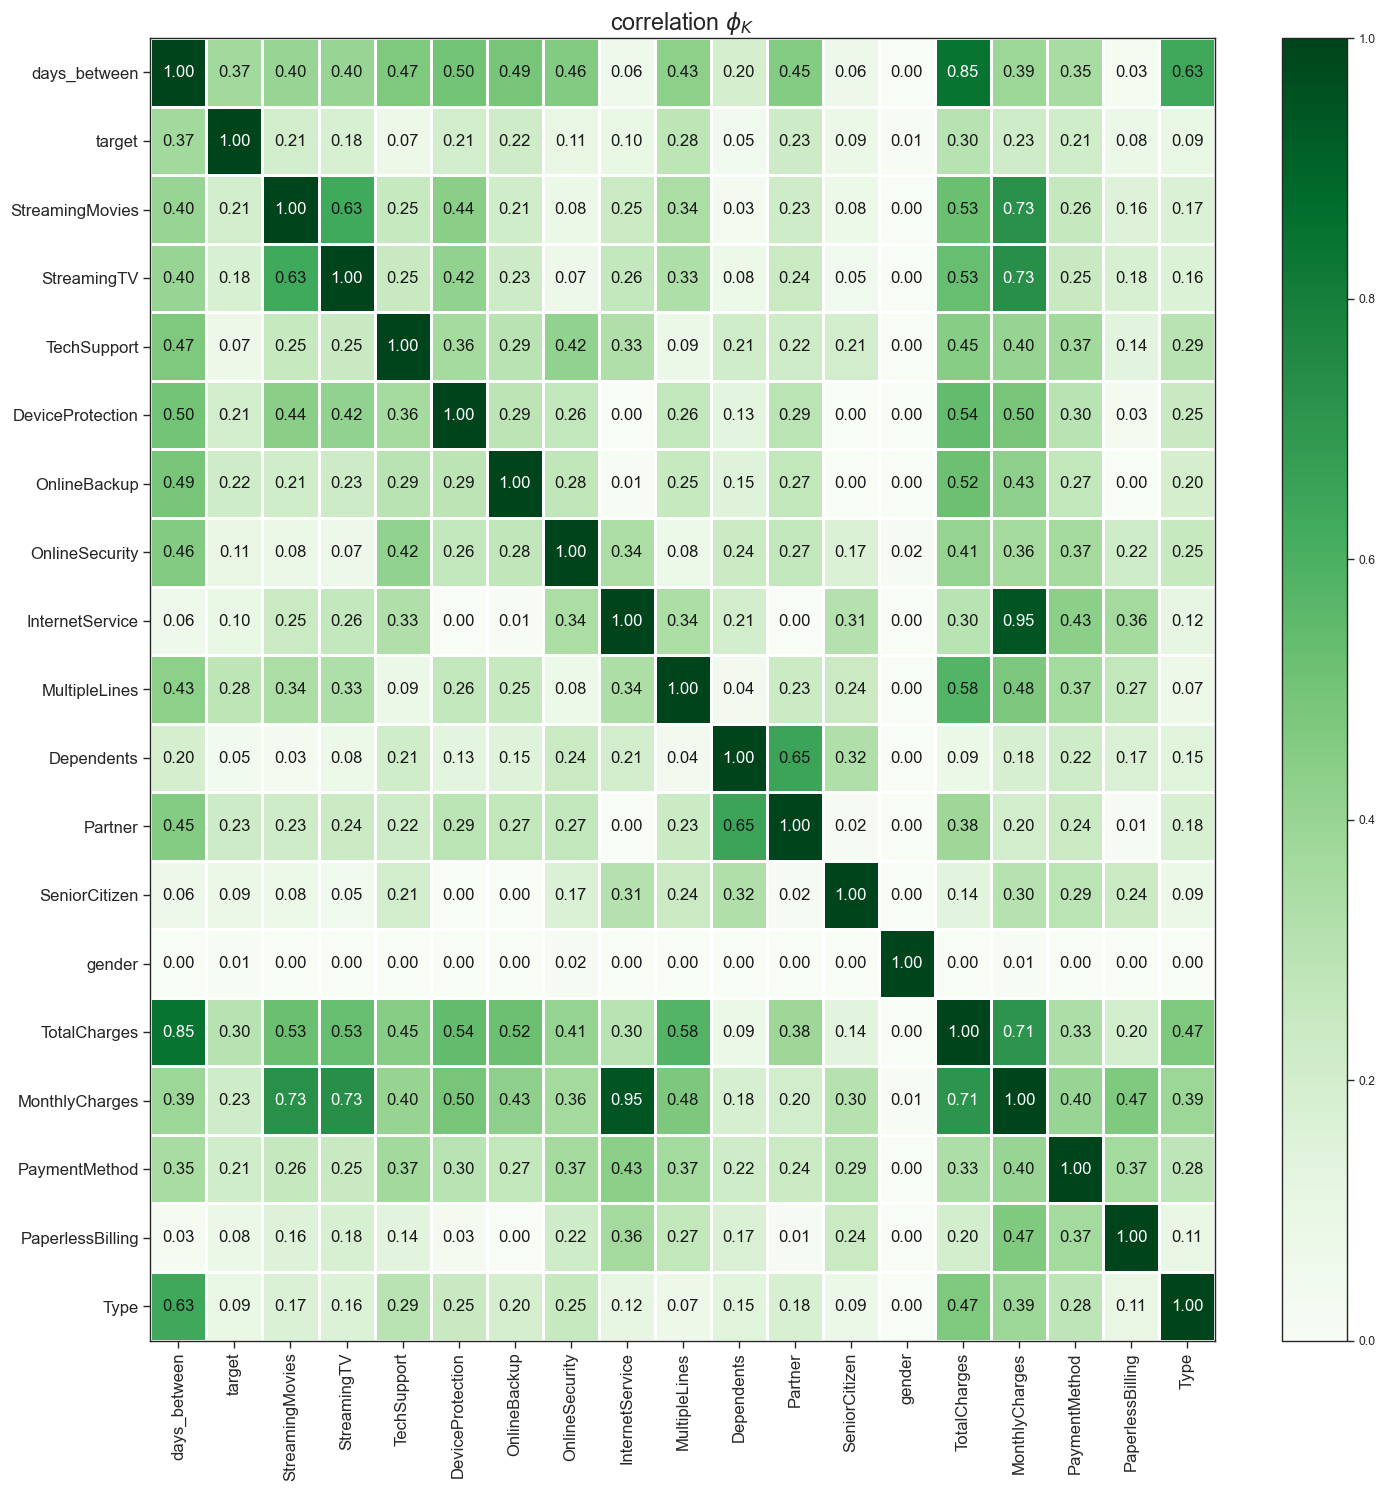

In [75]:
integer_columns = df_final.select_dtypes(include=['int64', 'float64']).columns.drop('target')
phik_overview_final = df_final.phik_matrix(interval_cols=integer_columns)
plot_correlation_matrix(phik_overview_final.values, 
                        x_labels=phik_overview_final.columns, 
                        y_labels=phik_overview_final.index, 
                        vmin=0, vmax=1, color_map="Greens", 
                        title=r"correlation $\phi_K$", 
                        fontsize_factor=1.2, 
                        figsize=(15, 15))
plt.tight_layout()

In [76]:
get_data_info(df_final)

количество строк и столбцов: (7043, 19)


Type PaperlessBilling              PaymentMethod  \
3064  Month-to-month              Yes           Electronic check   
4788        Two year               No    Credit card (automatic)   
4647  Month-to-month               No               Mailed check   
6900        One year              Yes  Bank transfer (automatic)   
1354  Month-to-month              Yes           Electronic check   

      MonthlyCharges  TotalCharges  gender SeniorCitizen Partner Dependents  \
3064           68.65       1470.48  Female            No      No         No   
4788           54.15       3258.75    Male            No      No         No   
4647           45.25        181.00    Male            No     Yes        Yes   
6900           94.00       5081.64    Male           Yes      No         No   
1354           88.35       1767.00  Female            No      No         No   

     MultipleLines InternetService OnlineSecurity OnlineBackup  \
3064            No     Fiber optic             No           No   
4788           Yes             DSL             No           No   
4647            No             DSL             No           No   
6900            No     Fiber optic             No           No   
1354           Yes     Fiber optic             No           No   

     DeviceProtection TechSupport StreamingTV StreamingMovies  target  \
3064               No          No          No              No       0   
4788              Yes          No          No              No       0   
4647               No          No          No              No       0   
6900              Yes          No         Yes             Yes       0   
1354               No         Yes         Yes              No       0   

      days_between  
3064         641.0  
4788        1798.0  
4647         123.0  
6900        1553.0  
1354         610.0

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 19 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Type              7043 non-null   object 
 1   PaperlessBilling  7043 non-null   object 
 2   PaymentMethod     7043 non-null   object 
 3   MonthlyCharges    7043 non-null   float64
 4   TotalCharges      7032 non-null   float64
 5   gender            7043 non-null   object 
 6   SeniorCitizen     7043 non-null   object 
 7   Partner           7043 non-null   object 
 8   Dependents        7043 non-null   object 
 9   MultipleLines     6361 non-null   object 
 10  InternetService   5517 non-null   object 
 11  OnlineSecurity    5517 non-null   object 
 12  OnlineBackup      5517 non-null   object 
 13  DeviceProtection  5517 non-null   object 
 14  TechSupport       5517 non-null   object 
 15  StreamingTV       5517 non-null   object 
 16  StreamingMovies   5517 non-null   object 


Type PaperlessBilling     PaymentMethod  MonthlyCharges  \
count             7043             7043              7043     7043.000000   
unique               3                2                 4             NaN   
top     Month-to-month              Yes  Electronic check             NaN   
freq              3875             4171              2365             NaN   
mean               NaN              NaN               NaN       64.761692   
std                NaN              NaN               NaN       30.090047   
min                NaN              NaN               NaN       18.250000   
25%                NaN              NaN               NaN       35.500000   
50%                NaN              NaN               NaN       70.350000   
75%                NaN              NaN               NaN       89.850000   
max                NaN              NaN               NaN      118.750000   

        TotalCharges gender SeniorCitizen Partner Dependents MultipleLines  \
count    7032.000000   7043          7043    7043       7043          6361   
unique           NaN      2             2       2          2             2   
top              NaN   Male            No      No         No            No   
freq             NaN   3555          5901    3641       4933          3390   
mean     2118.621822    NaN           NaN     NaN        NaN           NaN   
std      2112.736199    NaN           NaN     NaN        NaN           NaN   
min        19.050000    NaN           NaN     NaN        NaN           NaN   
25%       439.745000    NaN           NaN     NaN        NaN           NaN   
50%      1345.275000    NaN           NaN     NaN        NaN           NaN   
75%      3239.317500    NaN           NaN     NaN        NaN           NaN   
max      9221.380000    NaN           NaN     NaN        NaN           NaN   

       InternetService OnlineSecurity OnlineBackup DeviceProtection  \
count             5517           5517         5517             5517   
unique               2              2            2                2   
top        Fiber optic             No           No               No   
freq              3096           3498         3088             3095   
mean               NaN            NaN          NaN              NaN   
std                NaN            NaN          NaN              NaN   
min                NaN            NaN          NaN              NaN   
25%                NaN            NaN          NaN              NaN   
50%                NaN            NaN          NaN              NaN   
75%                NaN            NaN          NaN              NaN   
max                NaN            NaN          NaN              NaN   

       TechSupport StreamingTV StreamingMovies       target  days_between  
count         5517        5517            5517  7043.000000   7043.000000  
unique           2           2               2          NaN           NaN  
top             No          No              No          NaN           NaN  
freq          3473        2810            2785          NaN           NaN  
mean           NaN         NaN             NaN     0.156325    898.555729  
std            NaN         NaN             NaN     0.363189    683.130510  
min            NaN         NaN             NaN     0.000000      0.000000  
25%            NaN         NaN             NaN     0.000000    276.000000  
50%            NaN         NaN             NaN     0.000000    761.000000  
75%            NaN         NaN             NaN     0.000000   1461.000000  
max            NaN         NaN             NaN     1.000000   2314.000000

количество дубликатов: 4
количество пропусков:
 Type                   0
PaperlessBilling       0
PaymentMethod          0
MonthlyCharges         0
TotalCharges          11
gender                 0
SeniorCitizen          0
Partner                0
Dependents             0
MultipleLines        682
InternetService     1526
OnlineSecurity      1526
OnlineBackup        1526
DeviceProtection    1526
TechSupport         1526
StreamingTV         1526
StreamingMovies     1526
target                 0
days_between           0
dtype: int64


In [77]:
#df_final = df_final.drop_duplicates()

In [78]:
#выведем категориальные значения для работы 
cat_features = df_final.select_dtypes(include='object').columns.to_list()
print(cat_features)

['Type', 'PaperlessBilling', 'PaymentMethod', 'gender', 'SeniorCitizen', 'Partner', 'Dependents', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies']


Рассмотрим подробнее строки, где получились пропуски в столбце TotalCharges. Отметим, что дата действия договора - равна дате сбора информации, таким образом корректнее будет заполнить не медианным значением, чтобы предотвратить утечку, а значением из MonthlyCharges, при этом отметим, что тип договора у всех двухгодичный, проверим дополнительно логику оплаты (платится ли сразу за два года вся сумма и указывается в TotalCharges либо оплата идет ежемесячно при любом виде договора)

In [79]:
# выведем строки датасета с пропущенными значениями в столбце tenure
df_final.query('TotalCharges.isna()')

Type PaperlessBilling              PaymentMethod  MonthlyCharges  \
488   Two year              Yes  Bank transfer (automatic)           52.55   
753   Two year               No               Mailed check           20.25   
936   Two year               No               Mailed check           80.85   
1082  Two year               No               Mailed check           25.75   
1340  Two year               No    Credit card (automatic)           56.05   
3331  Two year               No               Mailed check           19.85   
3826  Two year               No               Mailed check           25.35   
4380  Two year               No               Mailed check           20.00   
5218  One year              Yes               Mailed check           19.70   
6670  Two year               No               Mailed check           73.35   
6754  Two year              Yes  Bank transfer (automatic)           61.90   

      TotalCharges  gender SeniorCitizen Partner Dependents MultipleLines  \
488            NaN  Female            No     Yes        Yes           NaN   
753            NaN    Male            No      No        Yes            No   
936            NaN  Female            No     Yes        Yes            No   
1082           NaN    Male            No     Yes        Yes           Yes   
1340           NaN  Female            No     Yes        Yes           NaN   
3331           NaN    Male            No     Yes        Yes            No   
3826           NaN    Male            No     Yes        Yes           Yes   
4380           NaN  Female            No     Yes        Yes            No   
5218           NaN    Male            No     Yes        Yes            No   
6670           NaN  Female            No     Yes        Yes           Yes   
6754           NaN    Male            No      No        Yes           Yes   

     InternetService OnlineSecurity OnlineBackup DeviceProtection TechSupport  \
488              DSL            Yes           No              Yes         Yes   
753              NaN            NaN          NaN              NaN         NaN   
936              DSL            Yes          Yes              Yes          No   
1082             NaN            NaN          NaN              NaN         NaN   
1340             DSL            Yes          Yes              Yes         Yes   
3331             NaN            NaN          NaN              NaN         NaN   
3826             NaN            NaN          NaN              NaN         NaN   
4380             NaN            NaN          NaN              NaN         NaN   
5218             NaN            NaN          NaN              NaN         NaN   
6670             DSL             No          Yes              Yes         Yes   
6754             DSL            Yes          Yes               No         Yes   

     StreamingTV StreamingMovies  target  days_between  
488          Yes              No       0           0.0  
753          NaN             NaN       0           0.0  
936          Yes             Yes       0           0.0  
1082         NaN             NaN       0           0.0  
1340         Yes              No       0           0.0  
3331         NaN             NaN       0           0.0  
3826         NaN             NaN       0           0.0  
4380         NaN             NaN       0           0.0  
5218         NaN             NaN       0           0.0  
6670         Yes              No       0           0.0  
6754          No              No       0           0.0

In [80]:
# проверим логику влияния BeginDate на TotalCharges 
df.query('BeginDate == "2019-11-01" & Type == "Two year"')

customerID  BeginDate    EndDate      Type PaperlessBilling  \
869   0323-XWWTN 2019-11-01 2020-02-01  Two year              Yes   
3193  1407-DIGZV 2019-11-01 2020-02-01  Two year               No   
6818  2710-WYVXG 2019-11-01 2020-02-01  Two year               No   

     PaymentMethod  MonthlyCharges  TotalCharges  gender  SeniorCitizen  ...  \
869   Mailed check            26.4         79.20    Male              0  ...   
3193  Mailed check            19.1         59.59  Female              0  ...   
6818  Mailed check            71.1        213.30  Female              0  ...   

     OnlineSecurity OnlineBackup DeviceProtection TechSupport StreamingTV  \
869             NaN          NaN              NaN         NaN         NaN   
3193            NaN          NaN              NaN         NaN         NaN   
6818            Yes          Yes               No         Yes          No   

     StreamingMovies target days_between months_between years_between  
869              NaN      0         92.0       3.022649      0.251887  
3193             NaN      0         92.0       3.022649      0.251887  
6818             Yes      0         92.0       3.022649      0.251887  

[3 rows x 24 columns]

Отметим, что при двухгодичном договоре сумма TotalCharges складывается из произведения месячных затрат на количество месяцев действия договора, таким образом - замена в пропусках TotalCharges (все пропуски датированы датой сбора информации) будет корректна значениями MonthlyCharges

In [81]:
#сохраним индексы для дальнейшей проверки заполнения
index_check = df.query('TotalCharges.isna()').index

In [82]:
df_final['TotalCharges'] = df_final['TotalCharges'].fillna(df_final['MonthlyCharges'])

In [83]:
df_final.iloc[index_check]

Type PaperlessBilling              PaymentMethod  MonthlyCharges  \
488   Two year              Yes  Bank transfer (automatic)           52.55   
753   Two year               No               Mailed check           20.25   
936   Two year               No               Mailed check           80.85   
1082  Two year               No               Mailed check           25.75   
1340  Two year               No    Credit card (automatic)           56.05   
3331  Two year               No               Mailed check           19.85   
3826  Two year               No               Mailed check           25.35   
4380  Two year               No               Mailed check           20.00   
5218  One year              Yes               Mailed check           19.70   
6670  Two year               No               Mailed check           73.35   
6754  Two year              Yes  Bank transfer (automatic)           61.90   

      TotalCharges  gender SeniorCitizen Partner Dependents MultipleLines  \
488          52.55  Female            No     Yes        Yes           NaN   
753          20.25    Male            No      No        Yes            No   
936          80.85  Female            No     Yes        Yes            No   
1082         25.75    Male            No     Yes        Yes           Yes   
1340         56.05  Female            No     Yes        Yes           NaN   
3331         19.85    Male            No     Yes        Yes            No   
3826         25.35    Male            No     Yes        Yes           Yes   
4380         20.00  Female            No     Yes        Yes            No   
5218         19.70    Male            No     Yes        Yes            No   
6670         73.35  Female            No     Yes        Yes           Yes   
6754         61.90    Male            No      No        Yes           Yes   

     InternetService OnlineSecurity OnlineBackup DeviceProtection TechSupport  \
488              DSL            Yes           No              Yes         Yes   
753              NaN            NaN          NaN              NaN         NaN   
936              DSL            Yes          Yes              Yes          No   
1082             NaN            NaN          NaN              NaN         NaN   
1340             DSL            Yes          Yes              Yes         Yes   
3331             NaN            NaN          NaN              NaN         NaN   
3826             NaN            NaN          NaN              NaN         NaN   
4380             NaN            NaN          NaN              NaN         NaN   
5218             NaN            NaN          NaN              NaN         NaN   
6670             DSL             No          Yes              Yes         Yes   
6754             DSL            Yes          Yes               No         Yes   

     StreamingTV StreamingMovies  target  days_between  
488          Yes              No       0           0.0  
753          NaN             NaN       0           0.0  
936          Yes             Yes       0           0.0  
1082         NaN             NaN       0           0.0  
1340         Yes              No       0           0.0  
3331         NaN             NaN       0           0.0  
3826         NaN             NaN       0           0.0  
4380         NaN             NaN       0           0.0  
5218         NaN             NaN       0           0.0  
6670         Yes              No       0           0.0  
6754          No              No       0           0.0

In [84]:
get_data_info(df_final)

количество строк и столбцов: (7043, 19)


Type PaperlessBilling              PaymentMethod  \
6525        Two year               No               Mailed check   
604         One year              Yes  Bank transfer (automatic)   
5843        One year              Yes  Bank transfer (automatic)   
2573  Month-to-month              Yes               Mailed check   
2837  Month-to-month               No               Mailed check   

      MonthlyCharges  TotalCharges  gender SeniorCitizen Partner Dependents  \
6525           20.50       1150.05    Male            No     Yes        Yes   
604           109.55       3505.60  Female            No      No         No   
5843           81.60       2856.00    Male           Yes     Yes         No   
2573           54.75        113.88  Female            No      No         No   
2837           20.50         41.00  Female            No      No         No   

     MultipleLines InternetService OnlineSecurity OnlineBackup  \
6525            No             NaN            NaN          NaN   
604            Yes     Fiber optic            Yes           No   
5843           Yes     Fiber optic             No           No   
2573            No             DSL             No           No   
2837            No             NaN            NaN          NaN   

     DeviceProtection TechSupport StreamingTV StreamingMovies  target  \
6525              NaN         NaN         NaN             NaN       0   
604               Yes         Yes         Yes             Yes       0   
5843              Yes          No          No              No       0   
2573               No          No          No             Yes       0   
2837              NaN         NaN         NaN             NaN       0   

      days_between  
6525        1676.0  
604          975.0  
5843        1067.0  
2573          62.0  
2837          62.0

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 19 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Type              7043 non-null   object 
 1   PaperlessBilling  7043 non-null   object 
 2   PaymentMethod     7043 non-null   object 
 3   MonthlyCharges    7043 non-null   float64
 4   TotalCharges      7043 non-null   float64
 5   gender            7043 non-null   object 
 6   SeniorCitizen     7043 non-null   object 
 7   Partner           7043 non-null   object 
 8   Dependents        7043 non-null   object 
 9   MultipleLines     6361 non-null   object 
 10  InternetService   5517 non-null   object 
 11  OnlineSecurity    5517 non-null   object 
 12  OnlineBackup      5517 non-null   object 
 13  DeviceProtection  5517 non-null   object 
 14  TechSupport       5517 non-null   object 
 15  StreamingTV       5517 non-null   object 
 16  StreamingMovies   5517 non-null   object 


Type PaperlessBilling     PaymentMethod  MonthlyCharges  \
count             7043             7043              7043     7043.000000   
unique               3                2                 4             NaN   
top     Month-to-month              Yes  Electronic check             NaN   
freq              3875             4171              2365             NaN   
mean               NaN              NaN               NaN       64.761692   
std                NaN              NaN               NaN       30.090047   
min                NaN              NaN               NaN       18.250000   
25%                NaN              NaN               NaN       35.500000   
50%                NaN              NaN               NaN       70.350000   
75%                NaN              NaN               NaN       89.850000   
max                NaN              NaN               NaN      118.750000   

        TotalCharges gender SeniorCitizen Partner Dependents MultipleLines  \
count    7043.000000   7043          7043    7043       7043          6361   
unique           NaN      2             2       2          2             2   
top              NaN   Male            No      No         No            No   
freq             NaN   3555          5901    3641       4933          3390   
mean     2115.377573    NaN           NaN     NaN        NaN           NaN   
std      2112.678861    NaN           NaN     NaN        NaN           NaN   
min        19.050000    NaN           NaN     NaN        NaN           NaN   
25%       436.750000    NaN           NaN     NaN        NaN           NaN   
50%      1343.350000    NaN           NaN     NaN        NaN           NaN   
75%      3236.690000    NaN           NaN     NaN        NaN           NaN   
max      9221.380000    NaN           NaN     NaN        NaN           NaN   

       InternetService OnlineSecurity OnlineBackup DeviceProtection  \
count             5517           5517         5517             5517   
unique               2              2            2                2   
top        Fiber optic             No           No               No   
freq              3096           3498         3088             3095   
mean               NaN            NaN          NaN              NaN   
std                NaN            NaN          NaN              NaN   
min                NaN            NaN          NaN              NaN   
25%                NaN            NaN          NaN              NaN   
50%                NaN            NaN          NaN              NaN   
75%                NaN            NaN          NaN              NaN   
max                NaN            NaN          NaN              NaN   

       TechSupport StreamingTV StreamingMovies       target  days_between  
count         5517        5517            5517  7043.000000   7043.000000  
unique           2           2               2          NaN           NaN  
top             No          No              No          NaN           NaN  
freq          3473        2810            2785          NaN           NaN  
mean           NaN         NaN             NaN     0.156325    898.555729  
std            NaN         NaN             NaN     0.363189    683.130510  
min            NaN         NaN             NaN     0.000000      0.000000  
25%            NaN         NaN             NaN     0.000000    276.000000  
50%            NaN         NaN             NaN     0.000000    761.000000  
75%            NaN         NaN             NaN     0.000000   1461.000000  
max            NaN         NaN             NaN     1.000000   2314.000000

количество дубликатов: 4
количество пропусков:
 Type                   0
PaperlessBilling       0
PaymentMethod          0
MonthlyCharges         0
TotalCharges           0
gender                 0
SeniorCitizen          0
Partner                0
Dependents             0
MultipleLines        682
InternetService     1526
OnlineSecurity      1526
OnlineBackup        1526
DeviceProtection    1526
TechSupport         1526
StreamingTV         1526
StreamingMovies     1526
target                 0
days_between           0
dtype: int64


### предотвращение утечки данных

применим pipeline для предотвращения утечки данных

### Разбиение данных на обучающую и тестовые выборки, кодирование данных

- разбиваем на обучающую и тестовую в размере 3 к 1
- выделим фичи для cat boost (категориальные) отдельно, чтобы кодировку catboost сделал сам
- для деревянных моделей и линейной регрессии применим кодировку OHE

In [85]:
features = df_final.drop(['target'], axis=1)
target = df_final['target']

X_train, X_test, y_train, y_test = train_test_split(
    features, target, test_size=0.25, random_state=RANDOM_STATE, stratify=target
)

In [86]:
# вывыедем информацию о количестве строк
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(5282, 18)
(1761, 18)
(5282,)
(1761,)


In [87]:
# автоматизируем вывод информации о балансе классов
def balance_class(dataframe):
    class_frequency = dataframe.value_counts(normalize=True)
    print('численное отношение классов целевого признака:')
    print(class_frequency)

    class_frequency.plot(kind='bar', figsize=(10, 5), title = 'распределение целевого признака', color = 'c')
    print()

численное отношение классов целевого признака:
0    0.84362
1    0.15638
Name: target, dtype: float64



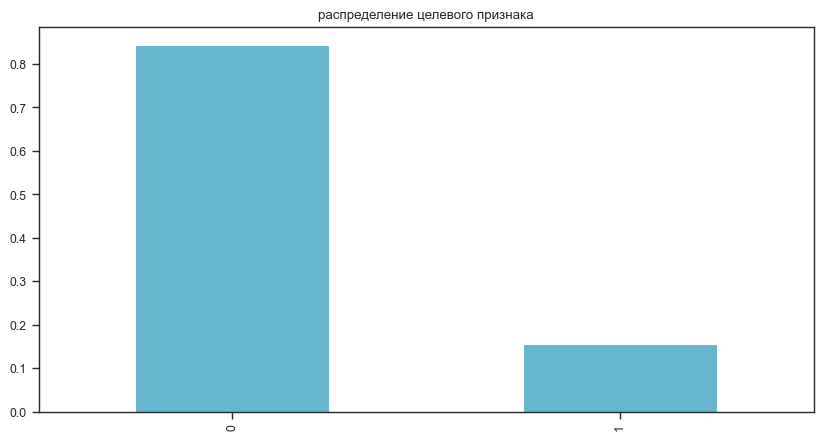

In [88]:
# проверим баланс классов для обучающей выборки
balance_class(y_train)

численное отношение классов целевого признака:
0    0.843839
1    0.156161
Name: target, dtype: float64



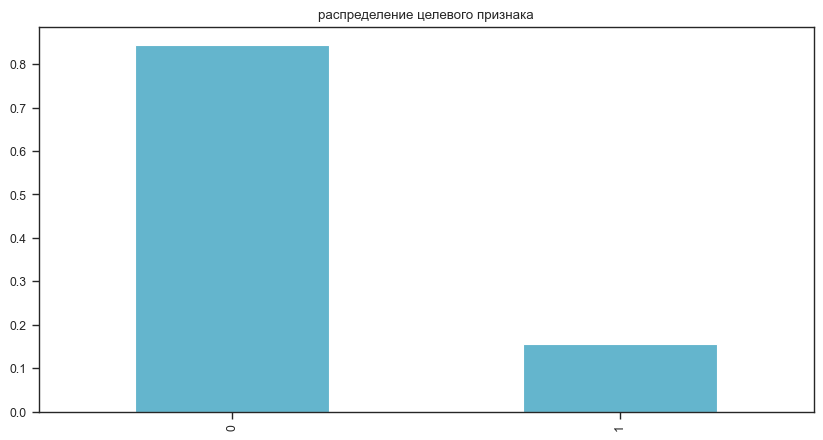

In [89]:
# проверим баланс классов для тестовой выборки
balance_class(y_test)

По классам все хорошо - сбалансированно распределились по выборкам

In [90]:
#категориальные признаки
cat_features = X_train.select_dtypes(include='object').columns.to_list()
print(cat_features)

['Type', 'PaperlessBilling', 'PaymentMethod', 'gender', 'SeniorCitizen', 'Partner', 'Dependents', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies']


In [91]:
#численные признаки
num_features = X_train.select_dtypes(exclude='object').columns.to_list()
print(num_features)

['MonthlyCharges', 'TotalCharges', 'days_between']


оформим кодировщик для линейной и деревянной модели.

In [92]:
col_transformer_line = make_column_transformer(
    (
        OneHotEncoder(drop='first', handle_unknown='ignore'),
        cat_features
    ),
    (
        StandardScaler(), 
        num_features
    ),
    verbose_feature_names_out=False
)


In [93]:
col_transformer_rfc = make_column_transformer(
    (
        OrdinalEncoder(encoded_missing_value=-1),
        cat_features
    ),
    (
        StandardScaler(), 
        num_features
    ),
    verbose_feature_names_out=False
)


Оформим предварительные данные для работы Catboost

In [94]:
X_train_cat = X_train.copy()

In [95]:
X_test_cat = X_test.copy()

In [96]:
X_train_cat[cat_features] = X_train_cat[cat_features].fillna('no_info')

In [97]:
X_test_cat[cat_features] = X_test_cat[cat_features].fillna('no_info')

In [98]:
train_data = Pool(data=X_train_cat,
                  label=y_train,
                  cat_features=cat_features
                 )

In [99]:
params = {'cat_features': cat_features,
              'custom_loss': 'AUC',
          'loss_function': 'Logloss',
              'learning_rate': 0.15,
              'verbose':100}

In [100]:
cv_data = cv(
    params = params,
    pool = train_data,
    fold_count=5,
    shuffle=True,
    partition_random_seed=0,
    stratified=False,
    verbose=False,
    early_stopping_rounds=200, 
)

Training on fold [0/5]

bestTest = 0.2783931371
bestIteration = 404

Training on fold [1/5]

bestTest = 0.2610758667
bestIteration = 414

Training on fold [2/5]

bestTest = 0.2339335445
bestIteration = 831

Training on fold [3/5]

bestTest = 0.2625021961
bestIteration = 386

Training on fold [4/5]

bestTest = 0.2118878329
bestIteration = 742



### Подбор гиперпараметров

Для Catboost подбор гипераметров через внутренние механизмы модели, для деревянных и линейной модели - RandomizeSearchCV и GridSearchCV, кросс-валидация.


оформим пайплайн для линейной модели Ridge

In [101]:
model_ridge = Ridge(random_state=RANDOM_STATE)

In [102]:
pipeline_ridge = make_pipeline(col_transformer_line, model_ridge)

In [103]:
# словарь с гиперпараметрами и значениями, которые хотим перебрать
param_grid_ridge = {
    'ridge__alpha': np.arange(0, 0.21, 0.01),
}

In [104]:
gs_ridge_pl = GridSearchCV(
    pipeline_ridge, 
    param_grid=param_grid_ridge, 
    scoring='roc_auc', 
    n_jobs=-1)

In [105]:
gs_ridge_pl.fit(X_train, y_train)

GridSearchCV(estimator=Pipeline(steps=[('columntransformer',
                                        ColumnTransformer(transformers=[('onehotencoder',
                                                                         OneHotEncoder(drop='first',
                                                                                       handle_unknown='ignore'),
                                                                         ['Type',
                                                                          'PaperlessBilling',
                                                                          'PaymentMethod',
                                                                          'gender',
                                                                          'SeniorCitizen',
                                                                          'Partner',
                                                                          'Dependents',
                                                                          'MultipleLines',
                                                                          'InternetService',
                                                                          'OnlineSecurity',
                                                                          'OnlineBackup',
                                                                          'DeviceProtection',
                                                                          'TechSupport',
                                                                          'StreamingTV',
                                                                          'StreamingMovies']),
                                                                        ('standardscaler',
                                                                         StandardScaler(),
                                                                         ['MonthlyCharges',
                                                                          'TotalCharges',
                                                                          'days_between'])],
                                                          verbose_feature_names_out=False)),
                                       ('ridge', Ridge(random_state=30723))]),
             n_jobs=-1,
             param_grid={'ridge__alpha': array([0.  , 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1 ,
       0.11, 0.12, 0.13, 0.14, 0.15, 0.16, 0.17, 0.18, 0.19, 0.2 ])},
             scoring='roc_auc')

Оформим пайплайн для деревянной модели

In [106]:
model_rfc = RandomForestClassifier(random_state=RANDOM_STATE, class_weight='balanced')

In [107]:
pipline_rfc = make_pipeline(col_transformer_rfc, model_rfc)

In [108]:
param_grid_rfc = {
    'randomforestclassifier__n_estimators': range(50, 251, 50),
    'randomforestclassifier__max_depth': range(2, 15),
    'randomforestclassifier__min_samples_split': (2, 3, 4),
    'randomforestclassifier__min_samples_leaf': (1, 2, 3, 4)
}


In [109]:
# получается достаточно много комбинаций гиперпараметров при переборе
# будем использовать RandomizedSearchCV, он работает на много быстрее
gs_rfc = RandomizedSearchCV(
    pipline_rfc, 
    param_distributions=param_grid_rfc, 
    scoring='roc_auc', 
    n_jobs=-1, 
    random_state=RANDOM_STATE
)

In [110]:
gs_rfc.fit(X_train, y_train)

RandomizedSearchCV(estimator=Pipeline(steps=[('columntransformer',
                                              ColumnTransformer(transformers=[('ordinalencoder',
                                                                               OrdinalEncoder(encoded_missing_value=-1),
                                                                               ['Type',
                                                                                'PaperlessBilling',
                                                                                'PaymentMethod',
                                                                                'gender',
                                                                                'SeniorCitizen',
                                                                                'Partner',
                                                                                'Dependents',
                                                                                'MultipleLines',
                                                                                'InternetService',
                                                                                'OnlineSecurity',
                                                                                'OnlineBackup',
                                                                                'DeviceProtection',
                                                                                'TechSupport',
                                                                                'St...
                                             ('randomforestclassifier',
                                              RandomForestClassifier(class_weight='balanced',
                                                                     random_state=30723))]),
                   n_jobs=-1,
                   param_distributions={'randomforestclassifier__max_depth': range(2, 15),
                                        'randomforestclassifier__min_samples_leaf': (1,
                                                                                     2,
                                                                                     3,
                                                                                     4),
                                        'randomforestclassifier__min_samples_split': (2,
                                                                                      3,
                                                                                      4),
                                        'randomforestclassifier__n_estimators': range(50, 251, 50)},
                   random_state=30723, scoring='roc_auc')

In [111]:
model_cat = CatBoostClassifier(**params, random_state=RANDOM_STATE,eval_metric='AUC')

In [112]:
model_cat.fit(train_data, plot=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	total: 7.9ms	remaining: 7.89s
100:	total: 635ms	remaining: 5.65s
200:	total: 1.25s	remaining: 4.98s
300:	total: 1.87s	remaining: 4.35s
400:	total: 2.49s	remaining: 3.72s
500:	total: 3.13s	remaining: 3.11s
600:	total: 3.77s	remaining: 2.5s
700:	total: 4.38s	remaining: 1.87s
800:	total: 5.02s	remaining: 1.25s
900:	total: 5.64s	remaining: 620ms
999:	total: 6.26s	remaining: 0us


### Исследование моделей разной архитектуры

для исследования возьмем три модели: CatBoost, случайный лес и линейную модель.

итоги по модели Ridge:

In [113]:
gs_ridge_best_score = gs_ridge_pl.best_score_
gs_ridge_best_params = gs_ridge_pl.best_params_

In [114]:

# лучшее значение
print(f'best_score: {gs_ridge_best_score}')
# лучшие гиперпараметры
print(f'best_params: {gs_ridge_best_params}')

best_score: 0.7635400594011746
best_params: {'ridge__alpha': 0.19}


итоги по модели RFC

In [115]:
gs_rfc_best_score = gs_rfc.best_score_
gs_rfc_best_params = gs_rfc.best_params_

In [116]:

# лучшее значение
print(f'best_score: {gs_rfc_best_score}')
# лучшие гиперпараметры
print(f'best_params: {gs_rfc_best_params}')

best_score: 0.8266838224268763
best_params: {'randomforestclassifier__n_estimators': 150, 'randomforestclassifier__min_samples_split': 4, 'randomforestclassifier__min_samples_leaf': 3, 'randomforestclassifier__max_depth': 7}


итоги по модели CatBoost

In [117]:
print('значение AUC для CatBoost', max(cv_data['test-AUC-mean']))

значение AUC для CatBoost 0.9060014821706766


In [118]:
summary_table = {'модель':['RIDGE','RFC', 'CATBOOST'],

                'значение ROC AUC':[round(gs_ridge_best_score,2),
                                   round(gs_rfc_best_score,2),
                                   round(max(cv_data['test-AUC-mean']),2)]}

In [119]:
summary_table = pd.DataFrame(summary_table)

**значение параметров трех моделей сведены в таблицу, на обучающей выборке лучшие параметры у CatBoost**

In [120]:
summary_table

модель  значение ROC AUC
0     RIDGE              0.76
1       RFC              0.83
2  CATBOOST              0.91

### Проверка на тестовой выборке одной выбранной модели (predict_proba)

In [121]:
predicted_valid = model_cat.predict(X_test_cat)

In [122]:
probabilities_valid = model_cat.predict_proba(X_test_cat)

In [123]:
probabilities_one_valid = probabilities_valid[:, 1]

In [124]:
auc_roc = roc_auc_score (y_test, probabilities_one_valid)

In [125]:
print('значение метрики ROC AUC на тестовой выборке выбранной модели:',auc_roc)

значение метрики ROC AUC на тестовой выборке выбранной модели: 0.9034601737428117


In [126]:
print(
        'значение метрики f1 на тестовой выборке выбранной модели:', f1_score (y_test, predicted_valid)
    )

значение метрики f1 на тестовой выборке выбранной модели: 0.6898047722342732


#### график ROC

In [127]:
eval_pool = Pool(X_test_cat, y_test, cat_features=cat_features)
curve = get_roc_curve(model_cat, eval_pool)
(fpr, tpr, thresholds)=curve
roc_auc=sklearn.metrics.auc(fpr, tpr)

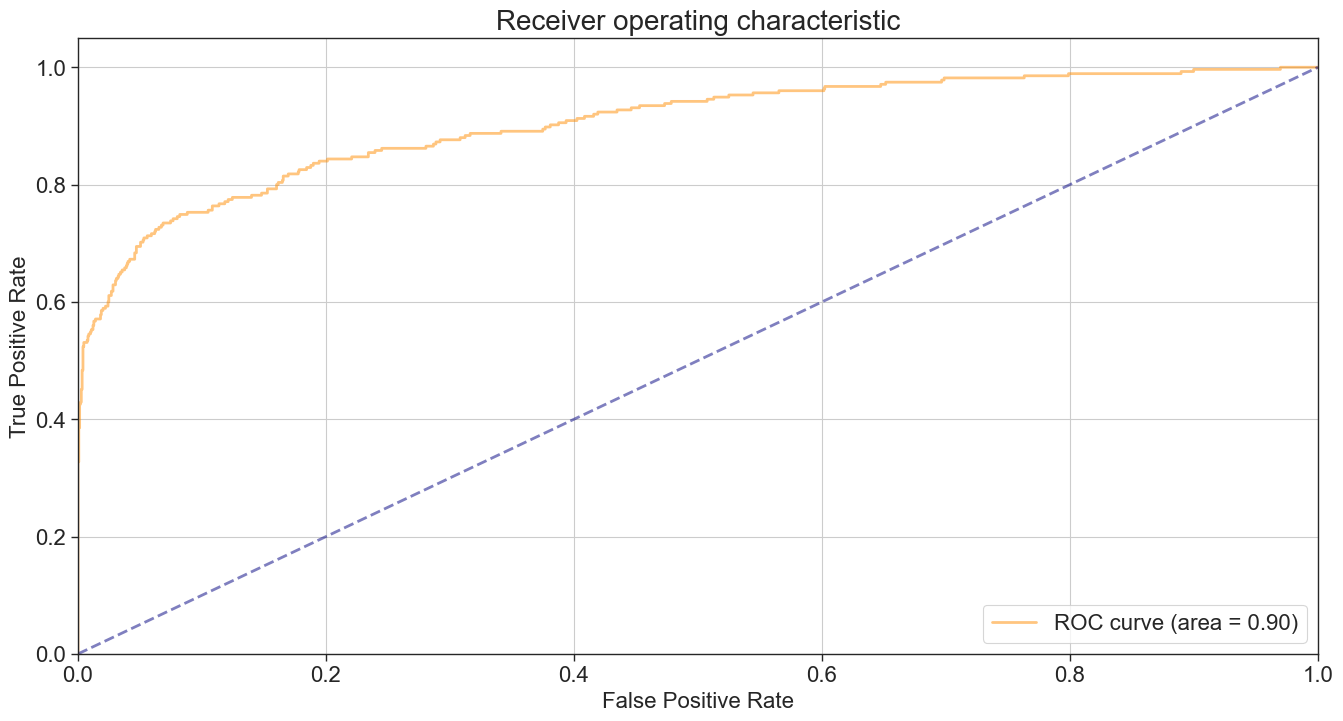

In [128]:
plt.figure(figsize=(16, 8))
lw=2

plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc, alpha=0.5)

plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--', alpha=0.5)

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.grid(True)
plt.xlabel('False Positive Rate', fontsize=16)
plt.ylabel('True Positive Rate', fontsize=16)
plt.title('Receiver operating characteristic', fontsize=20)
plt.legend(loc="lower right", fontsize=16)
plt.show()

#### Анализ второй метрики для интерпритации

In [129]:
print('значение метрики accuracy на тестовой выборке выбранной модели:', accuracy_score(y_test, predicted_valid))

значение метрики accuracy на тестовой выборке выбранной модели: 0.9187961385576378


#### матрица ошибок

In [130]:
    conf_matrix = (
        pd.DataFrame(confusion_matrix(y_test, predicted_valid), 
                     index = ['Предсказания 0', 'Предсказания 1'], 
                     columns = ['Ответы 0', 'Ответы 1'])
    )

Матрица ошибок
![avatar](https://t1.daumcdn.net/thumb/R1280x0/?fname=http://t1.daumcdn.net/brunch/service/user/4SKt/image/VwzVj8EgnrXLgUcZcs_seAUWEQg.png)



Маркетологи компании выделяют две болевые точки:
1) пользователю предложили промокоды, но он не собирался уходить (классический пример False Positive на нашем языке);  
2) пользователю ничего не предложили и он ушёл (как говорится, False Negative).

матрица ошибок (trashhold=0.5):


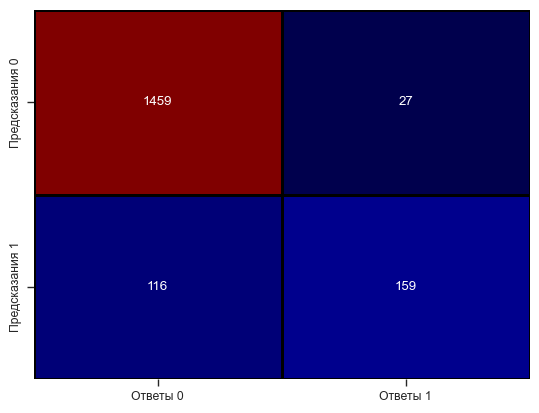

In [131]:
matrix_05 = sns.heatmap(conf_matrix, annot=True, fmt='.4g', cmap='seismic', linewidths=1, linecolor='black', cbar=False)  
    
print('матрица ошибок (trashhold=0.5):')
  #  print(conf_matrix)

В нашем случае численные показатели такие (из 1761 пользователей):

- 114 пользователю предложили промокоды, но они не собирались уходить  
- 25 пользователям ничего не предложили и он ушли

#### анализ важности признаков выбранной модели

Выведем значения влияние фичей на таргет по выбранной модели

In [132]:
model_cat.get_feature_importance(prettified=True)

Feature Id  Importances
0       days_between    37.098768
1     MonthlyCharges    11.263306
2       TotalCharges     9.351733
3               Type     7.110226
4      PaymentMethod     4.955628
5      MultipleLines     4.235605
6            Partner     3.219362
7   DeviceProtection     3.150710
8       OnlineBackup     3.015004
9        TechSupport     2.541410
10       StreamingTV     2.420926
11        Dependents     2.198346
12   StreamingMovies     1.991905
13    OnlineSecurity     1.843043
14            gender     1.828089
15  PaperlessBilling     1.680954
16     SeniorCitizen     1.154643
17   InternetService     0.940342

Теперь воспользуемся библиотекой shap, чтобы визуализировать наши фичи: 

In [133]:
features[cat_features] = features[cat_features].fillna('no_info')

In [134]:
explainer = shap.TreeExplainer(model_cat)
shap_values=explainer.shap_values(Pool(features, target, cat_features=cat_features))

shap.initjs()
shap.force_plot(explainer.expected_value, shap_values[3,:], features.iloc[3,:])

Как видим для третьего объекта фичи (красные линии) двигают наше предсказание в положительную сторону, к тому, что будет 1 (клиент уйдет) а синии линии уменьшают данную вероятность.

In [135]:
shap.initjs()
shap.force_plot(explainer.expected_value,shap_values[91, :], features.iloc[111, :])

Здесь ситуация иная, вероятность того, что пользователь уйдет намного больше, чем останется, слишком много фичей склоняют предсказание к отрицательному исходу.

Сделаем то же самое не для одного объекта, как это было в предыдущих двух случаях, а сразу, допустим, для ста объектов из нашей выборки:

In [136]:
X_small = features.iloc[0:100]
shap_small = shap_values[:100]
shap.force_plot(explainer.expected_value, shap_small, X_small)


По оси X у нас расположена шкала вклада значения фичи, по оси Y — количество объектов.

выведем визуально влияние фичей и как они влияют на предсказание

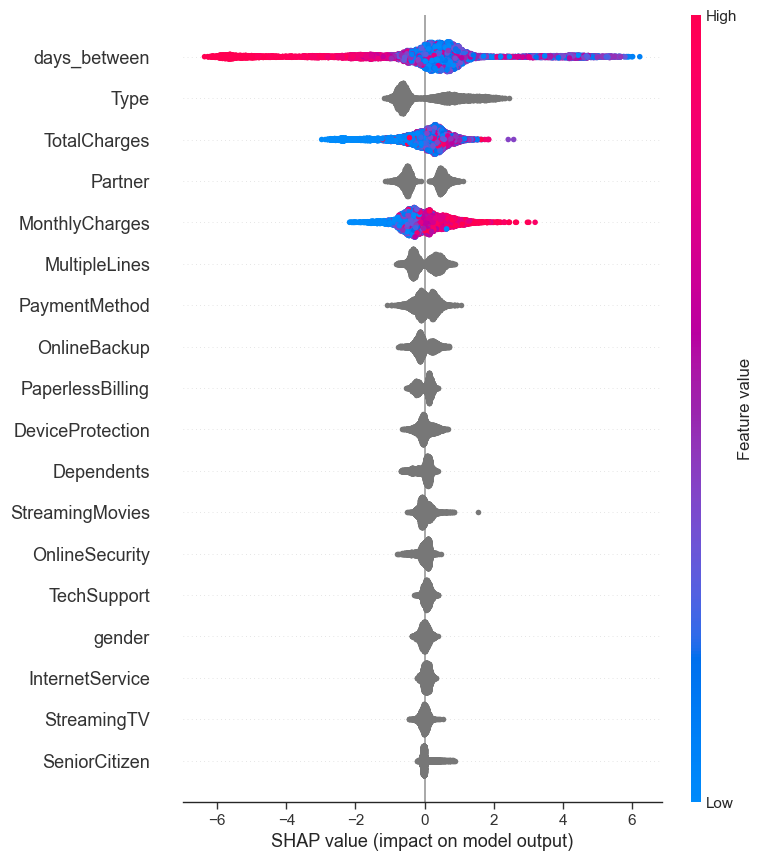

In [137]:
shap.summary_plot(shap_values, features)

Цветом показано значение фичи, чем краснее цвет – тем выше значение фичи, чем цвет более синий – тем меньше. Так же для каждой фичи набросаны точки, каждая точка соответствует одному объекту обучающей выборки, те точки, которые находятся правее серой черты – для них вклад от этой фичи положительный, но он не совсем большой, а которые левее, вклад большой, но не каждого из объектов обучающей выборки.

## Составление отчета

В рамках текущего проекта ставилась задача разработать качественную модель машинного обучения, предсказывающую уход клиентов. Основные шаги реализации задачи:
1. Анализ данных и предобработка данных. *данные изучены, объединены в один датасет и проведены подготовительные обработки данных с учетом предотвращения утечки данных, также удалены параметры с очень сильным влиянием на другие параметры*
2. Анализ различных моделей машинного обучения и проверка выбранной модели на тестовой выборке.

По итогам обработки данных и обучения трех разных моделей (линейная модель Ridge, ансамбль случайного леса RandomForestClassifier и модель градиентного бустинга CatBoost) были получены следующие результаты, критерием сравнения стала метрика ROC-AUC:

In [138]:
summary_table

модель  значение ROC AUC
0     RIDGE              0.76
1       RFC              0.83
2  CATBOOST              0.91

С учетом поставлевнной задачи, что ROC AUC больше 0,85 по итогам обучения и кросс-валидации подходит модель градиентного бустинга CatBoost. На тестировании модель показала допустимые результаты:

In [139]:
print('значение метрики ROC AUC на тестовой выборке CatBoost:',auc_roc)

значение метрики ROC AUC на тестовой выборке CatBoost: 0.9034601737428117


In [140]:
print('значение метрики accuracy на тестовой выборке CatBoost:', accuracy_score(y_test, predicted_valid))

значение метрики accuracy на тестовой выборке CatBoost: 0.9187961385576378


Датасет имел несколько признаков, вносящих сильное влияние, в том числе на утечку данных (к примеру, дата начала и конца действия договора), для качественного обучения модели и дальнейшего использования были сгенерированы дополнительные признаки и удалены сильно коррелирующие параметры. По результатам можно отметить следующий топ-10 влиящих признаков. Самые сильные параметры - это количество дней действия договора и ежемесячные, общие траты:

In [141]:
model_cat.get_feature_importance(prettified=True).head(10)

Feature Id  Importances
0      days_between    37.098768
1    MonthlyCharges    11.263306
2      TotalCharges     9.351733
3              Type     7.110226
4     PaymentMethod     4.955628
5     MultipleLines     4.235605
6           Partner     3.219362
7  DeviceProtection     3.150710
8      OnlineBackup     3.015004
9       TechSupport     2.541410

Параметры визуально имеют следующее влияние на предсказание (*чем краснее цвет – тем выше значение фичи, чем цвет более синий – тем меньше.*

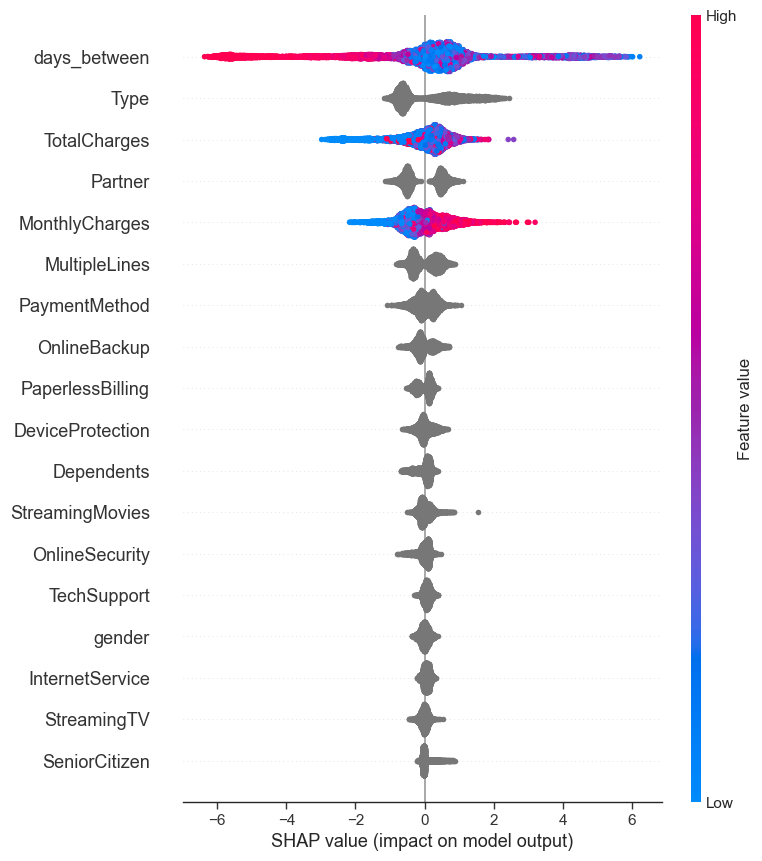

In [142]:
shap.summary_plot(shap_values, features)

В рамках поставки задачи были озвучены такие бизнес-метрики и боли:

1) пользователю предложили промокоды, но он не собирался уходить;  
2) пользователю ничего не предложили и он ушёл.

Модель CatBoost показала такие параметры:

Для теста были взяты данные по 1761 клиенту, из них:

1575 клиентов не ушли:
- 1461 клиента модель предсказала верно;
- 114 клиентам предложили промокоды, но они не собирались уходить

186 клиентов разорвали договор:  
- 161 клиент моделью был предсказан верно;
- 25 клиентам ничего не предложили и они ушли.

матрица ошибок (trashhold=0.5):


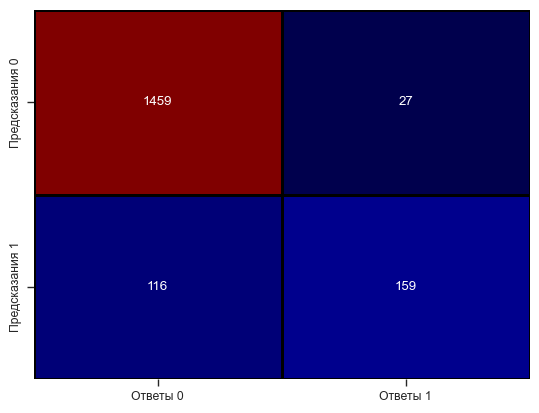

In [143]:
matrix_05 = sns.heatmap(conf_matrix, annot=True, fmt='.4g', cmap='seismic', linewidths=1, linecolor='black', cbar=False)  
    
print('матрица ошибок (trashhold=0.5):')
  #  print(conf_matrix)

Одной из рекомендацией при введении модели в эксплуатации будет изменение порога классфикации. Его можно будет подобрать вместе с маркетологами с учетом параметров бюджета на акции по удержанию клиентов и разной стоимости ошибок первого и второго рода в денежном выражении. 

К примеру, если будет уменьшен порог до 0,25/0,15 или увеличен до 0,75 то результаты будут следующие:

матрица ошибок (порог отсечки trashhold=0.25):


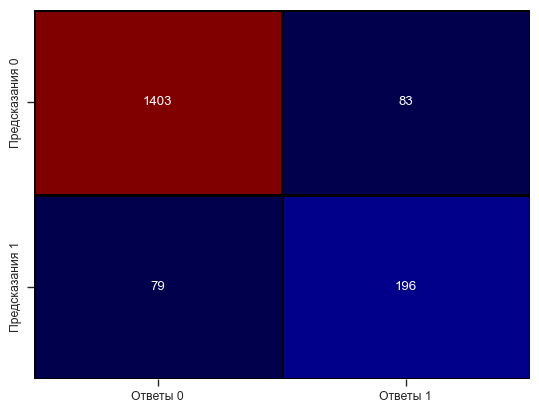

In [144]:
threshold_025 = 0.25
predicted_valid_025 = probabilities_one_valid > threshold_025
conf_matrix_025 = (
        pd.DataFrame(confusion_matrix(y_test, predicted_valid_025), 
                     index = ['Предсказания 0', 'Предсказания 1'], 
                     columns = ['Ответы 0', 'Ответы 1'])
    )
matrix_025 = sns.heatmap(conf_matrix_025, annot=True, fmt='.4g', cmap='seismic', linewidths=1, linecolor='black', cbar=False)  
    
print('матрица ошибок (порог отсечки trashhold=0.25):')
  #  print(conf_matrix)

Количество клиентов, которым ничего не предложили и они ушли увеличилось в три раза, а количество предсказанных клиентов, которым предложили промокоды, но они и не планировали уходить, снизилось в два раза

матрица ошибок (порог отсечки trashhold=0.15):


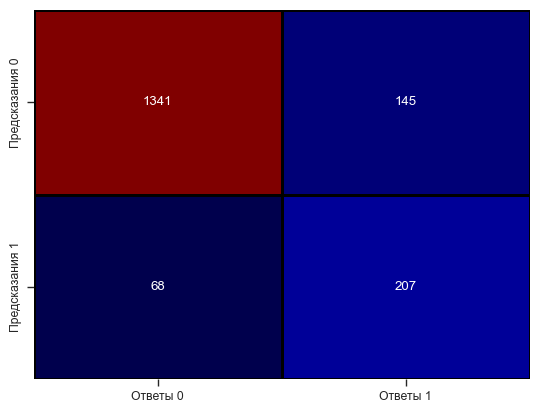

In [145]:
threshold_015 = 0.15
predicted_valid_015 = probabilities_one_valid > threshold_015
conf_matrix_015 = (
        pd.DataFrame(confusion_matrix(y_test, predicted_valid_015), 
                     index = ['Предсказания 0', 'Предсказания 1'], 
                     columns = ['Ответы 0', 'Ответы 1'])
    )
matrix_015 = sns.heatmap(conf_matrix_015, annot=True, fmt='.4g', cmap='seismic', linewidths=1, linecolor='black', cbar=False)  
    
print('матрица ошибок (порог отсечки trashhold=0.15):')
  #  print(conf_matrix)

еще при уменьшенеии порога растет количество ошибок, связанных с клиентами которым ничего не предложили, но они ушли.

матрица ошибок (порог отсечки trashhold=0.75):


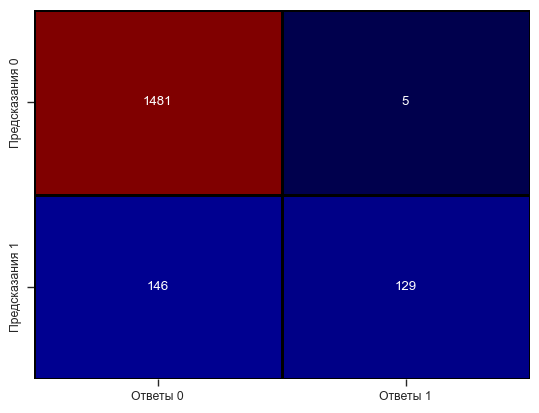

In [146]:
threshold_075 = 0.75
predicted_valid_075 = probabilities_one_valid > threshold_075
conf_matrix_075 = (
        pd.DataFrame(confusion_matrix(y_test, predicted_valid_075), 
                     index = ['Предсказания 0', 'Предсказания 1'], 
                     columns = ['Ответы 0', 'Ответы 1'])
    )
matrix_075 = sns.heatmap(conf_matrix_075, annot=True, fmt='.4g', cmap='seismic', linewidths=1, linecolor='black', cbar=False)  
    
print('матрица ошибок (порог отсечки trashhold=0.75):')
  #  print(conf_matrix)

Наоборот, при увеличении порога до 0,75 мы видим, что количество клиентов, которым ничего не предложили и они ушли сократилось с 25 до 6, но при этом ошибка предсказания клиентов, которым были предложены промокоды, но они планировали остаться возросло примерно в полтора раза относительно базового порога в 0,5.